# Setting up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install heartpy
%pip install wfdb
!git clone https://github.com/MIT-LCP/wfdb-python
%cd wfdb-python
%pip uninstall matplotlib
%pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 8.2 MB/s 
     |████████████████████████████████| 11.2 MB 52.8 MB/s 
     |████████████████████████████████| 930 kB 51.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
heartpy 1.2.7 requires matplotlib<=3.3.4; python_version == "3.7", but you have matplotlib 3.5.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Cloning into 'wfdb-python'...
remote: Enumerating objects: 5389, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 5389 (delta 108), reused 100 (delta 55), pack-reused 5203
Receiving objects: 100% (5389/5389), 165.85 MiB | 26.71 MiB/s, done.
Resolving deltas: 100% (3500/3500), done.
Checking out files: 100% (258/258), done.
/content/wfdb-python
Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/

# Downloading the MIMIC I records

05/30/2022, 15:41:24: Processing record 037
05/30/2022, 15:41:25: Processing record 039
05/30/2022, 15:41:27: Processing record 041
05/30/2022, 15:41:29: Processing record 055
05/30/2022, 15:41:31: Processing record 208
05/30/2022, 15:41:32: Processing record 209
05/30/2022, 15:41:33: Processing record 210
05/30/2022, 15:41:34: Processing record 211
05/30/2022, 15:41:35: Processing record 212
05/30/2022, 15:41:37: Processing record 213
05/30/2022, 15:41:39: Processing record 216
05/30/2022, 15:41:41: Processing record 218
05/30/2022, 15:41:43: Processing record 219
05/30/2022, 15:41:45: Processing record 220
05/30/2022, 15:41:46: Processing record 221
05/30/2022, 15:41:49: Processing record 222
05/30/2022, 15:41:49: Processing record 224
05/30/2022, 15:41:52: Processing record 225
05/30/2022, 15:41:54: Processing record 226
05/30/2022, 15:41:56: Processing record 230
05/30/2022, 15:41:59: Processing record 231
05/30/2022, 15:42:00: Processing record 237
05/30/2022, 15:42:02: Processing

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


05/30/2022, 15:42:39: Processing record 415
05/30/2022, 15:42:39: Processing record 417
05/30/2022, 15:42:41: Processing record 418
05/30/2022, 15:42:44: Processing record 427
05/30/2022, 15:42:46: Processing record 430
05/30/2022, 15:42:48: Processing record 437
05/30/2022, 15:42:50: Processing record 438
05/30/2022, 15:42:52: Processing record 439
05/30/2022, 15:42:55: Processing record 442
05/30/2022, 15:42:56: Processing record 443
05/30/2022, 15:42:58: Processing record 444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


05/30/2022, 15:43:01: Processing record 446
05/30/2022, 15:43:02: Processing record 449


/usr/local/lib/python3.7/dist-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


05/30/2022, 15:43:05: Processing record 450
05/30/2022, 15:43:05: Processing record 451
05/30/2022, 15:43:07: Processing record 452
05/30/2022, 15:43:09: Processing record 453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


05/30/2022, 15:43:11: Processing record 454
05/30/2022, 15:43:13: Processing record 456
05/30/2022, 15:43:14: Processing record 466
05/30/2022, 15:43:16: Processing record 471
05/30/2022, 15:43:18: Processing record 472


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


05/30/2022, 15:43:21: Processing record 474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


05/30/2022, 15:43:23: Processing record 476


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


05/30/2022, 15:43:26: Processing record 477
05/30/2022, 15:43:28: Processing record 480
05/30/2022, 15:43:30: Processing record 482
05/30/2022, 15:43:32: Processing record 484


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


05/30/2022, 15:43:34: Processing record 485


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


script finished


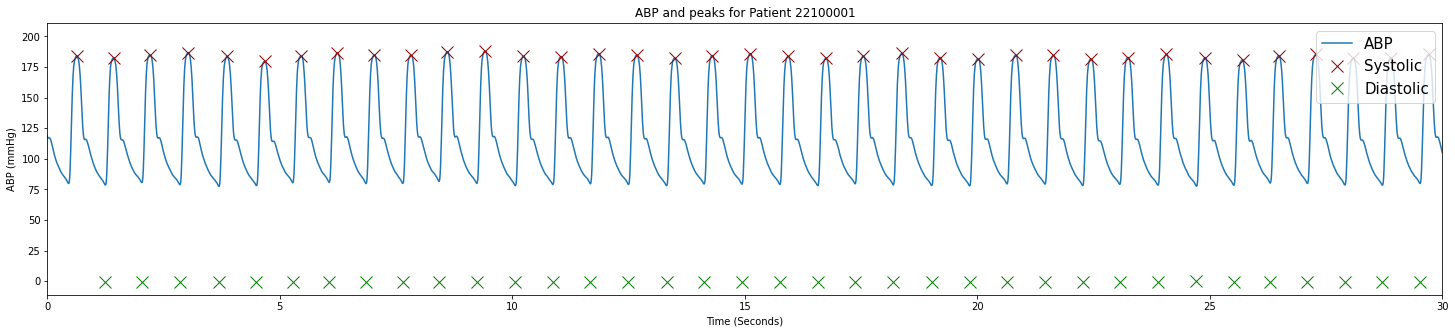

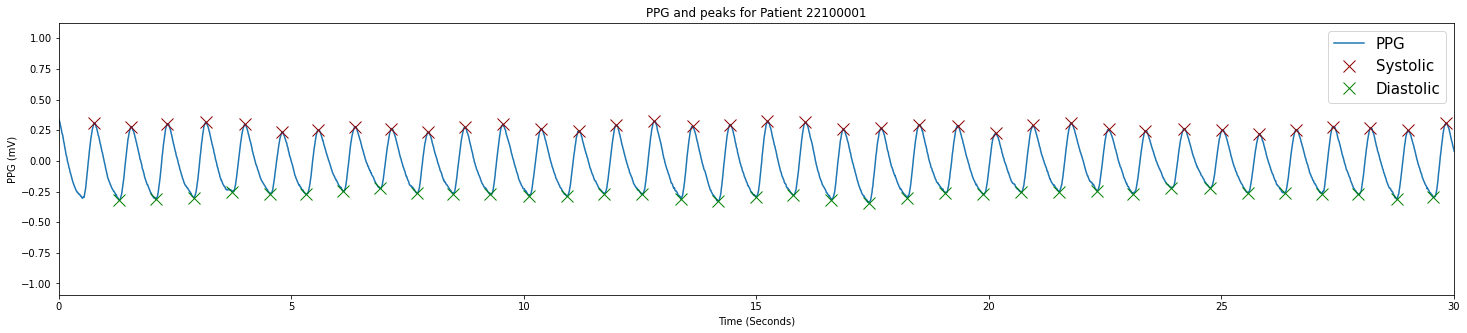

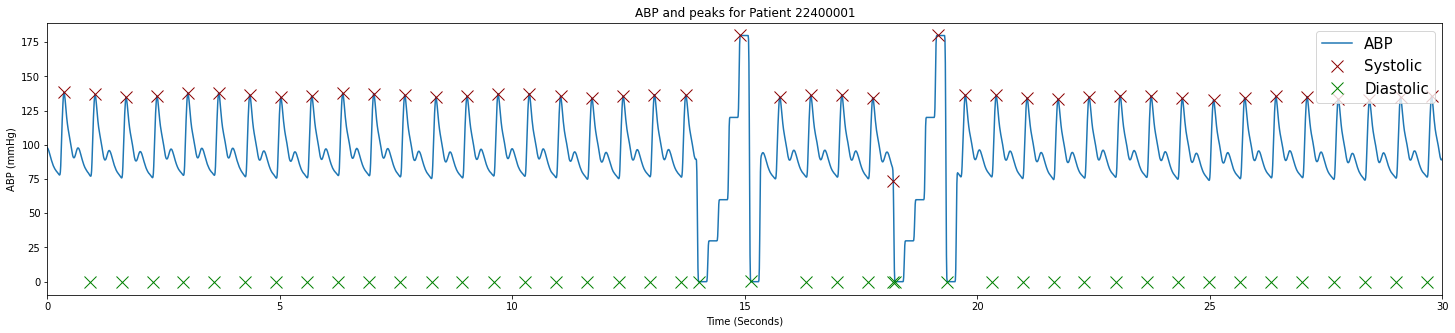

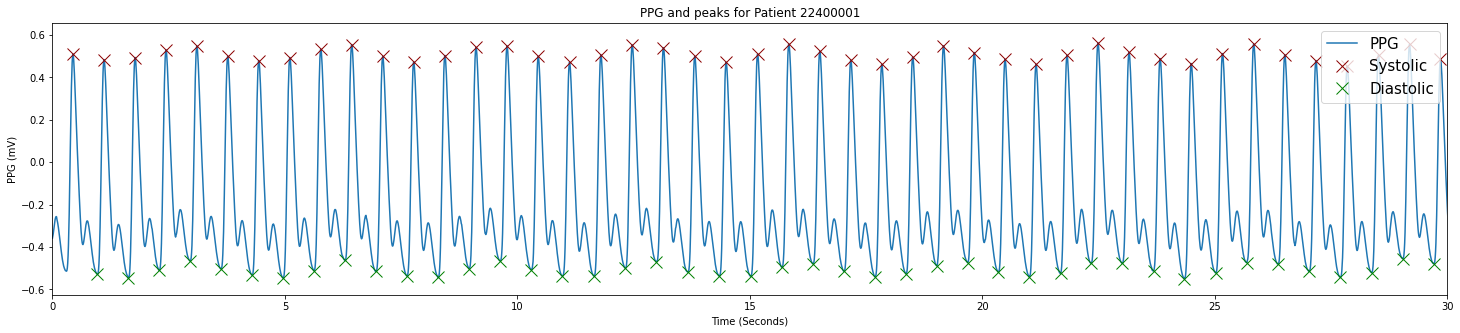

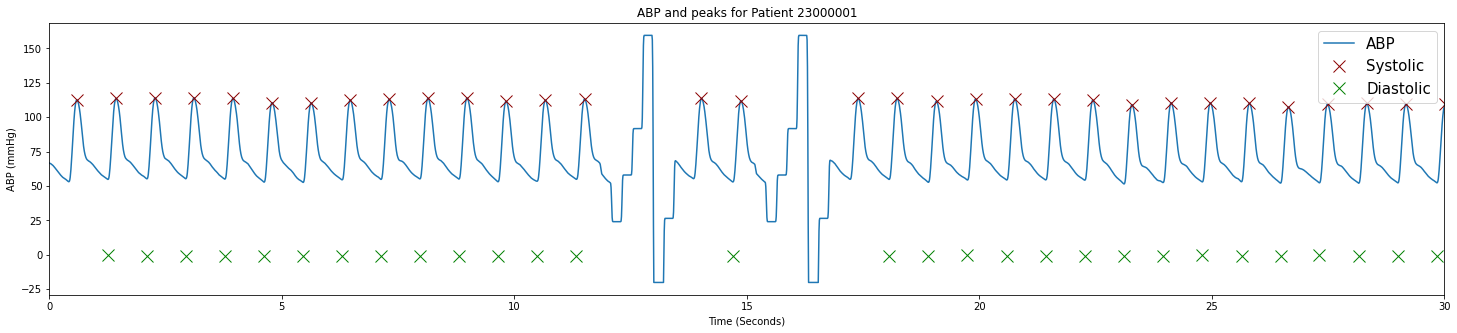

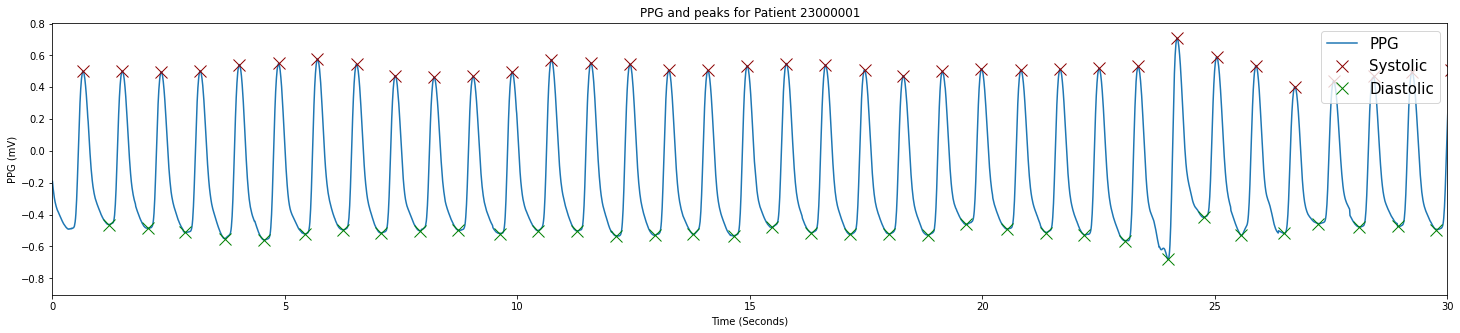

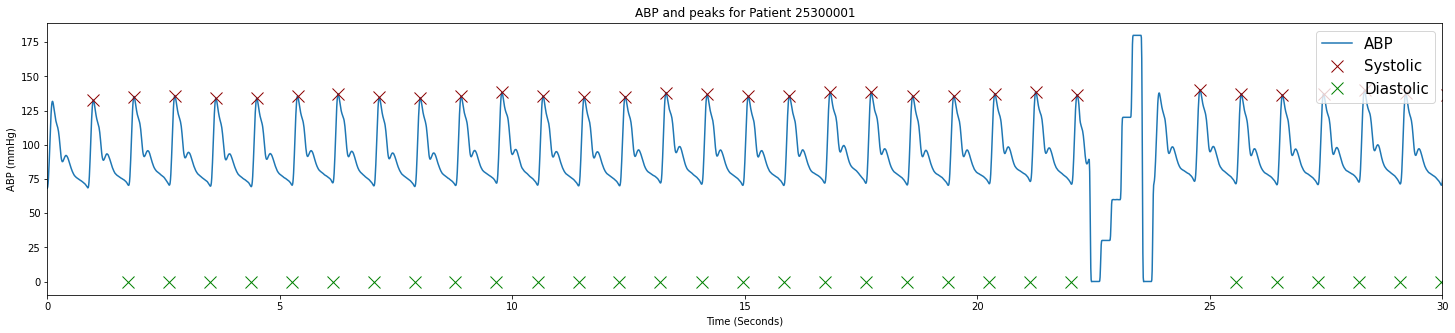

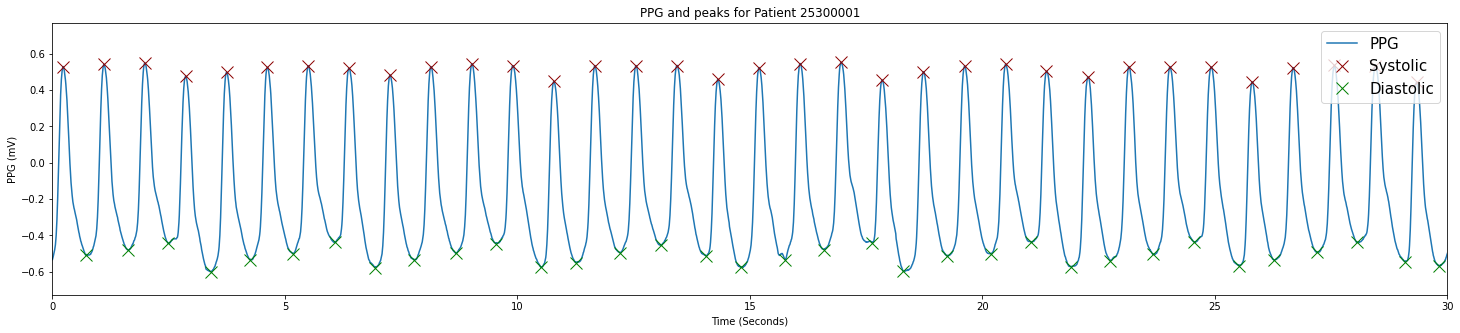

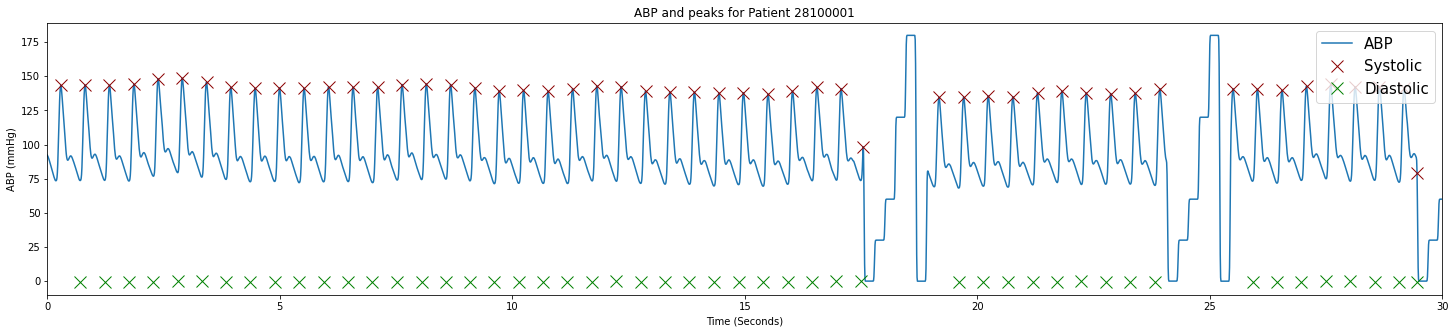

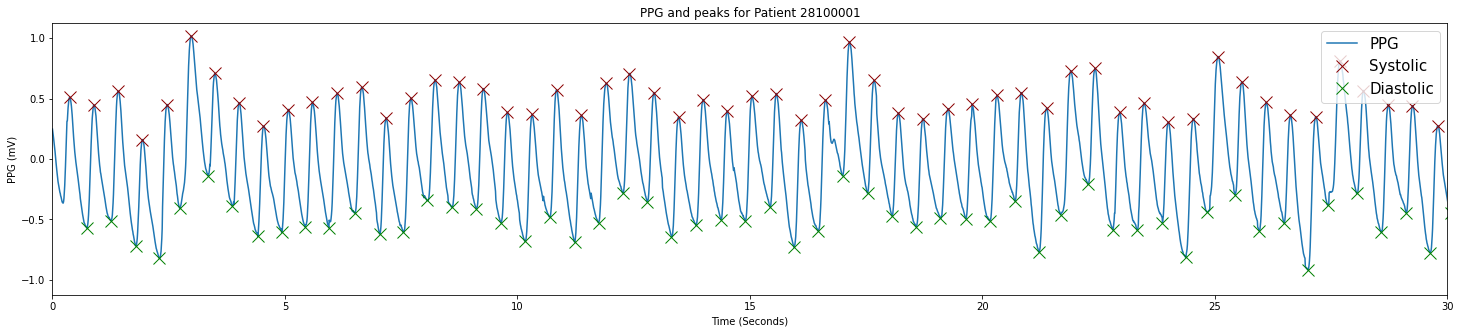

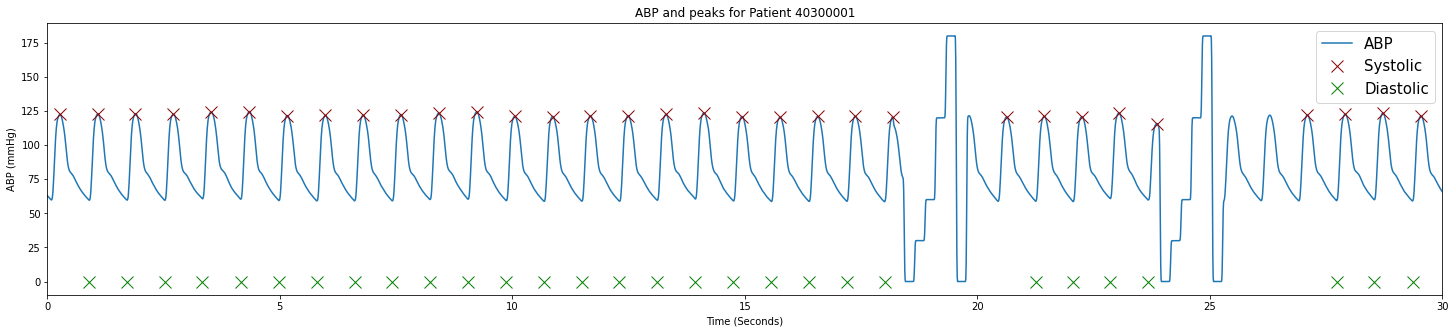

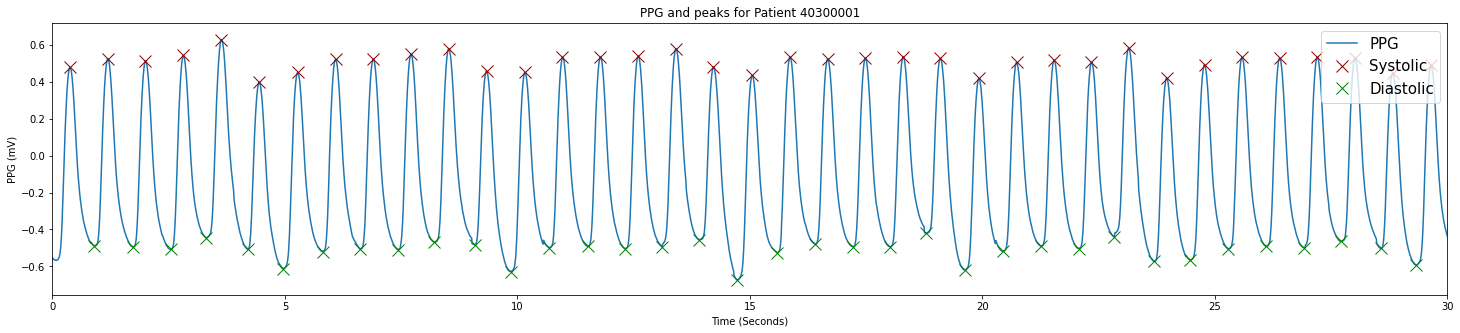

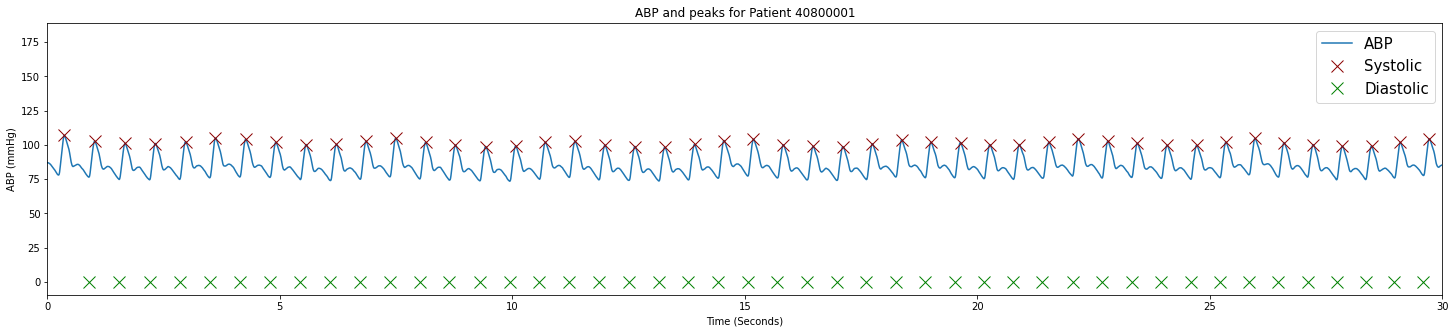

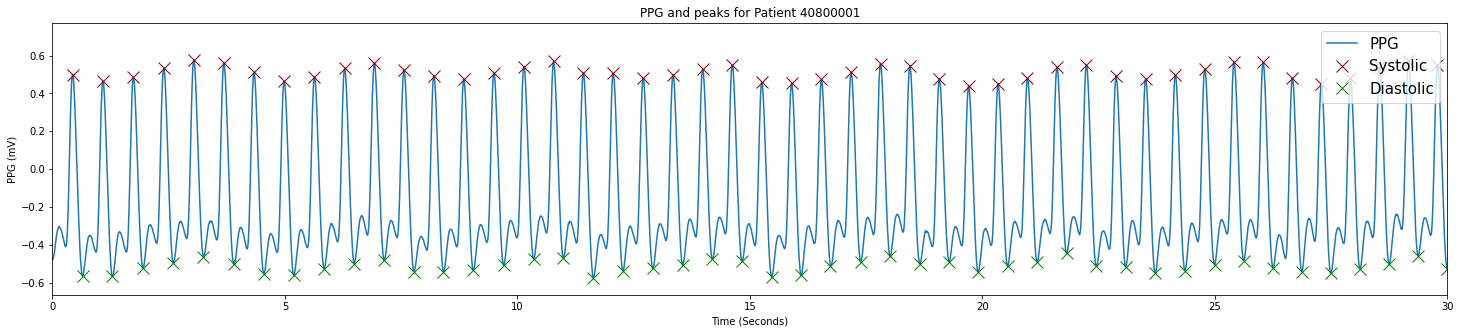

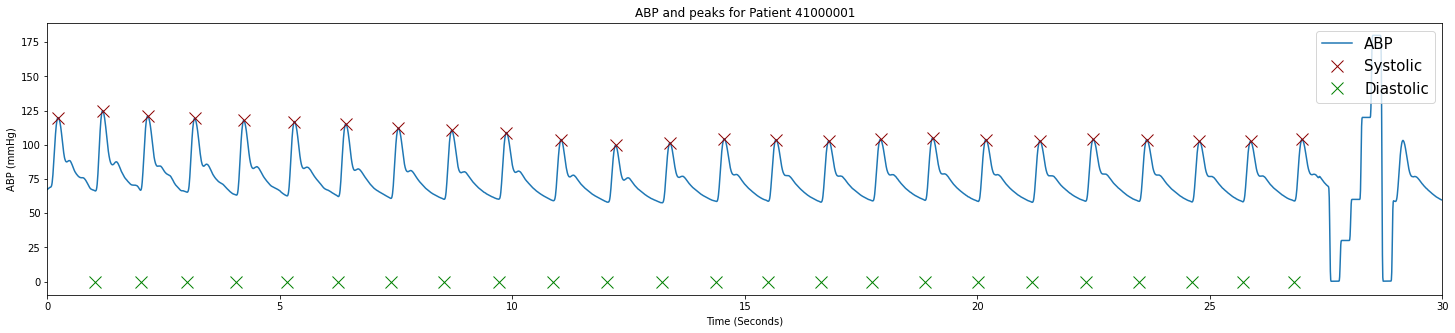

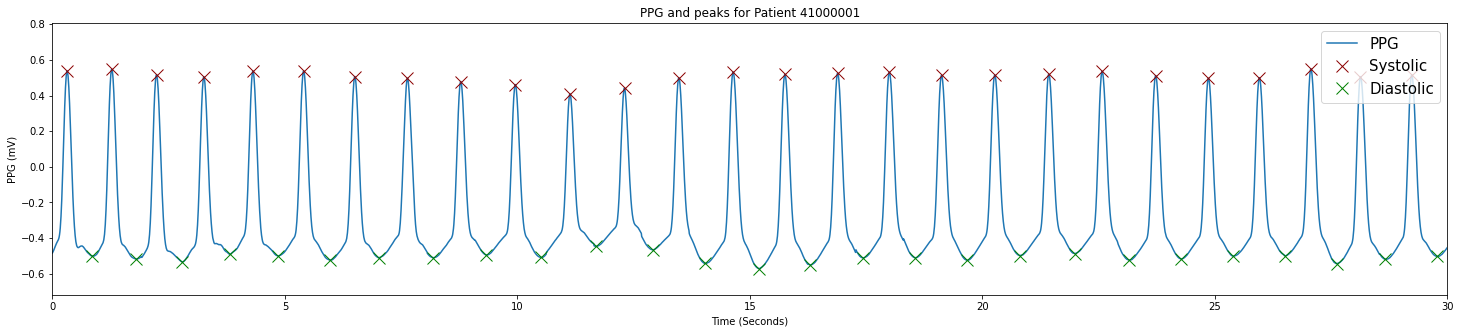

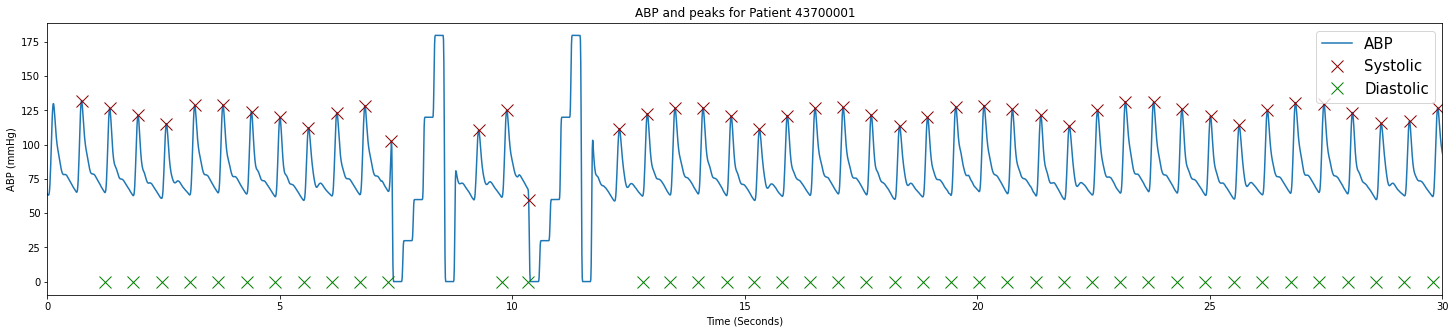

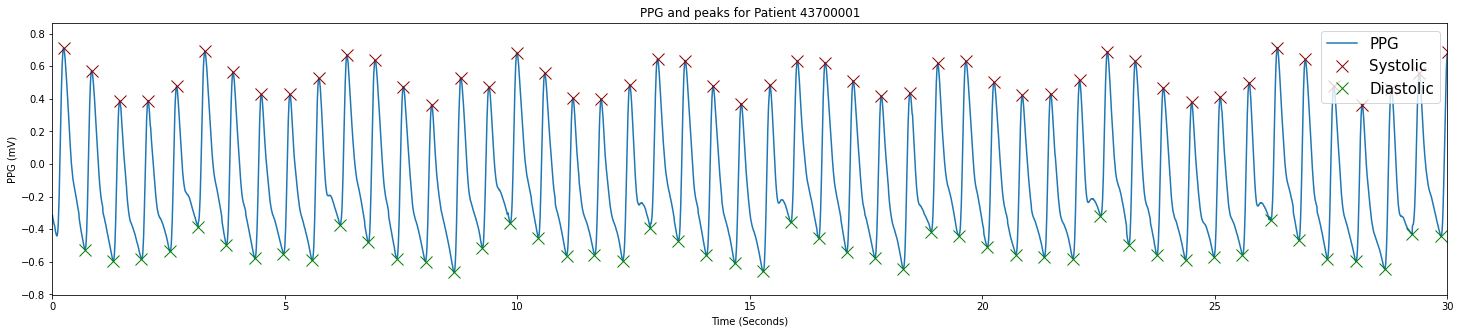

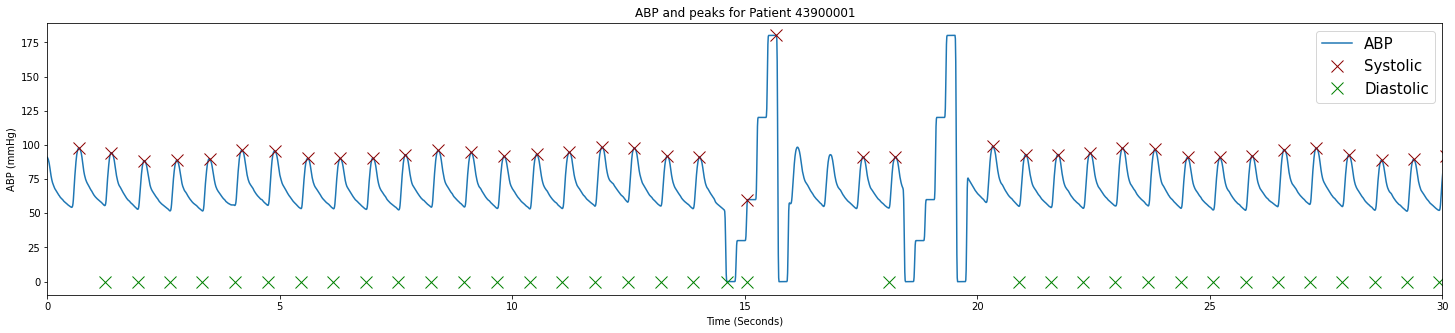

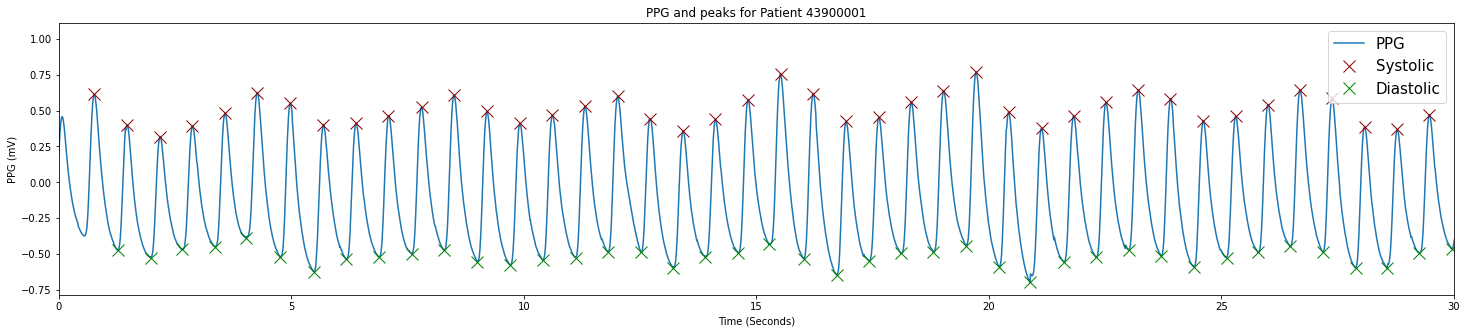

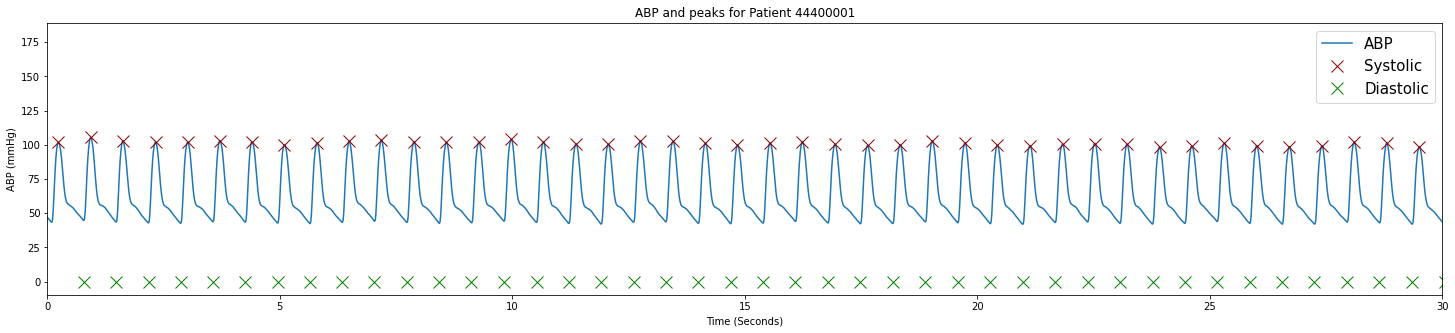

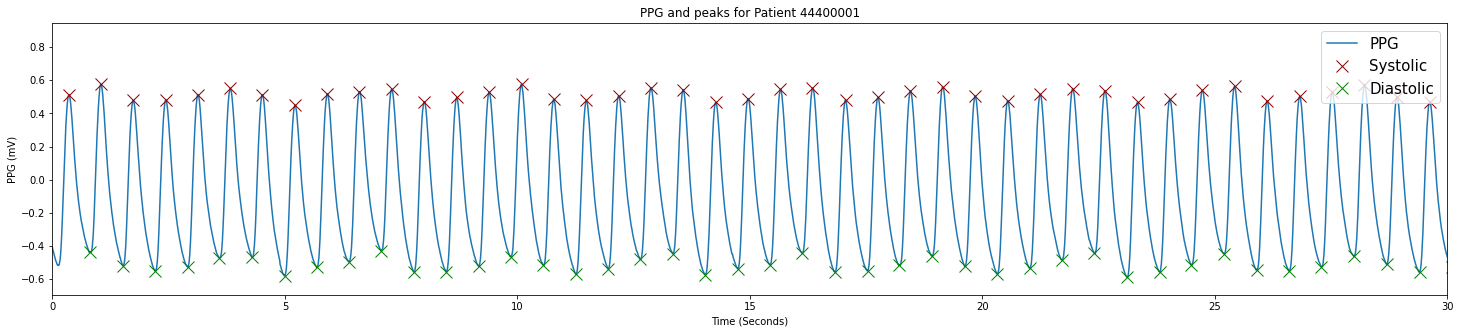

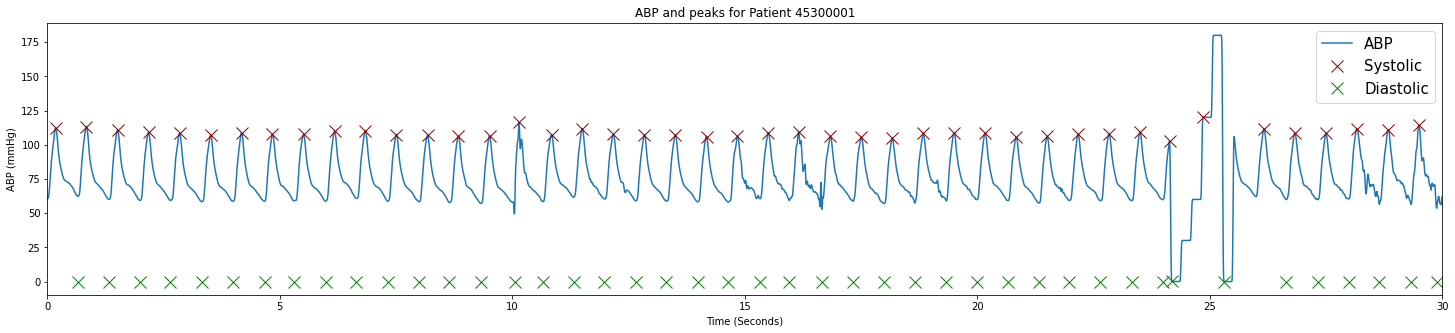

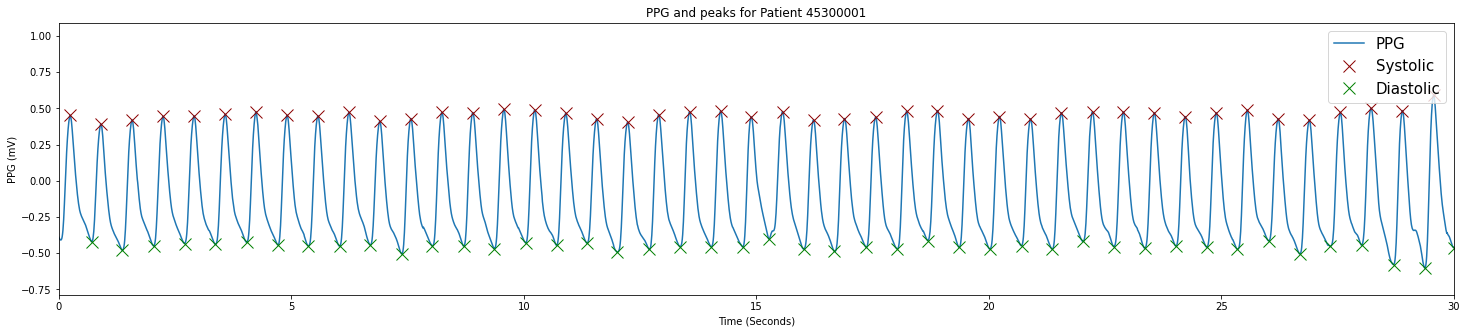

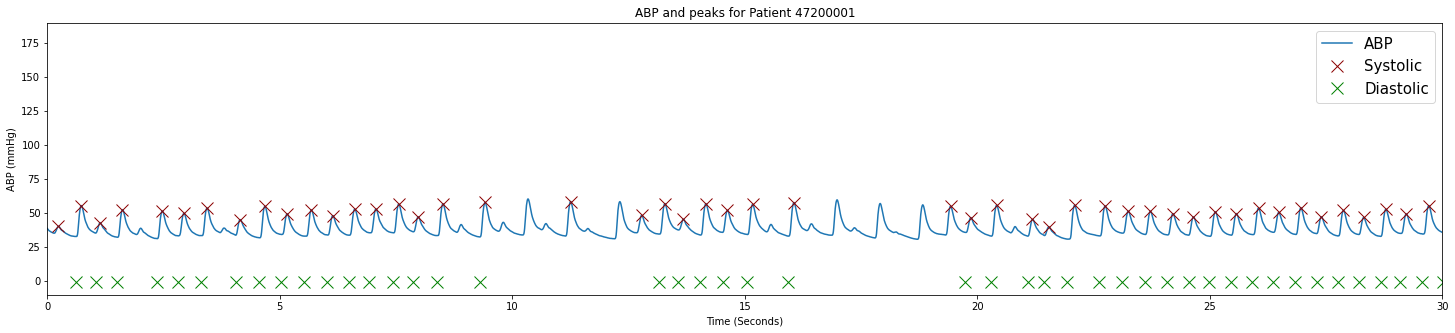

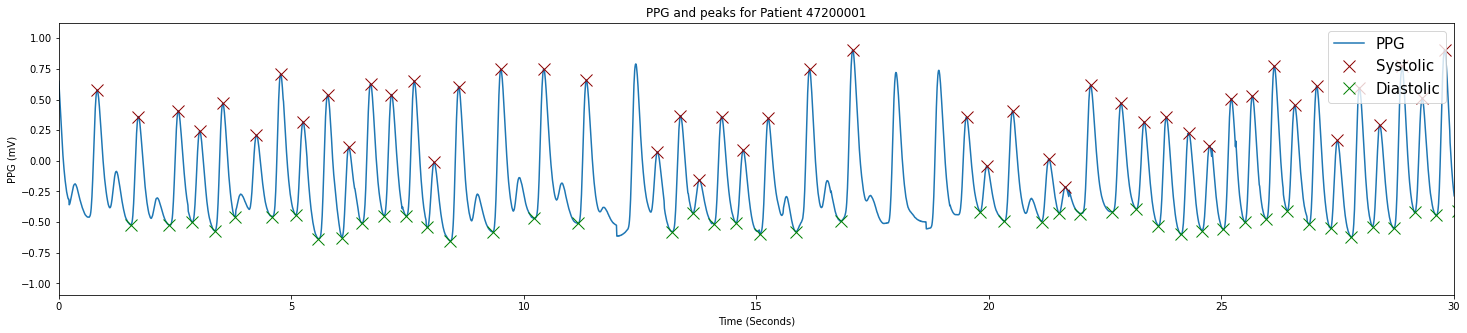

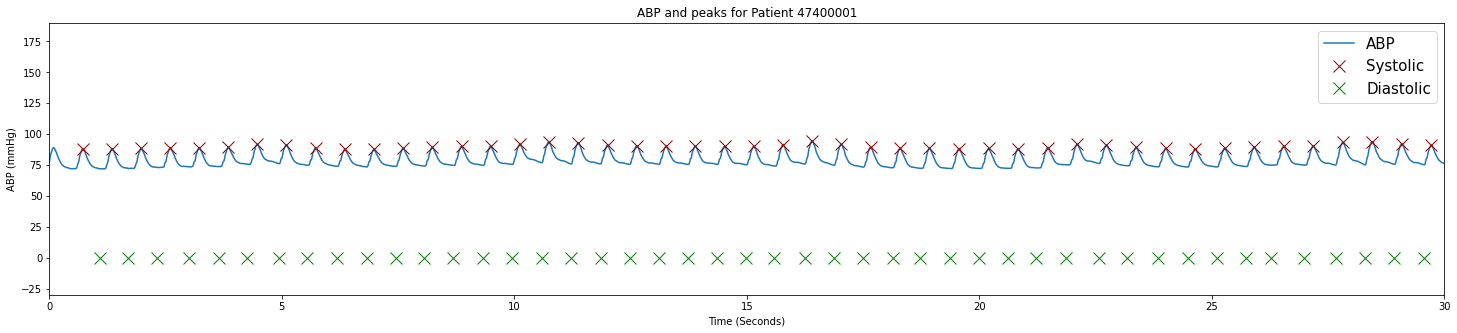

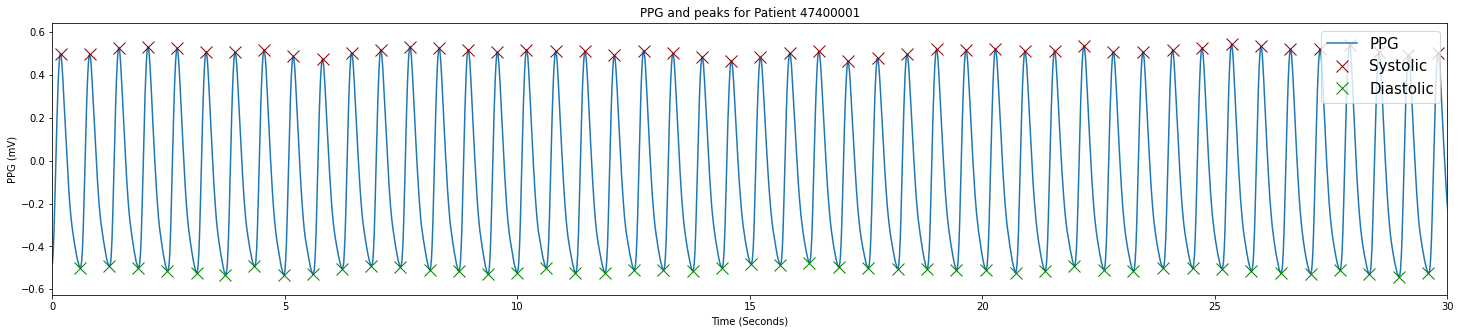

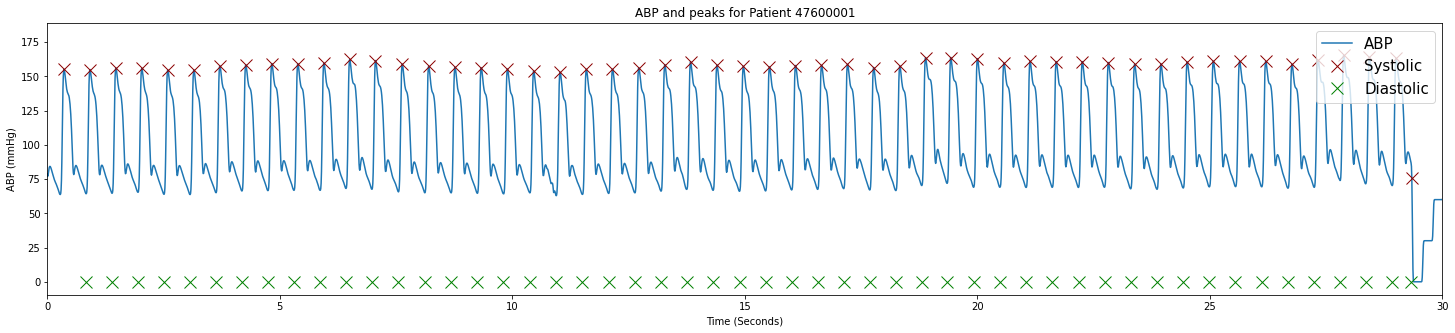

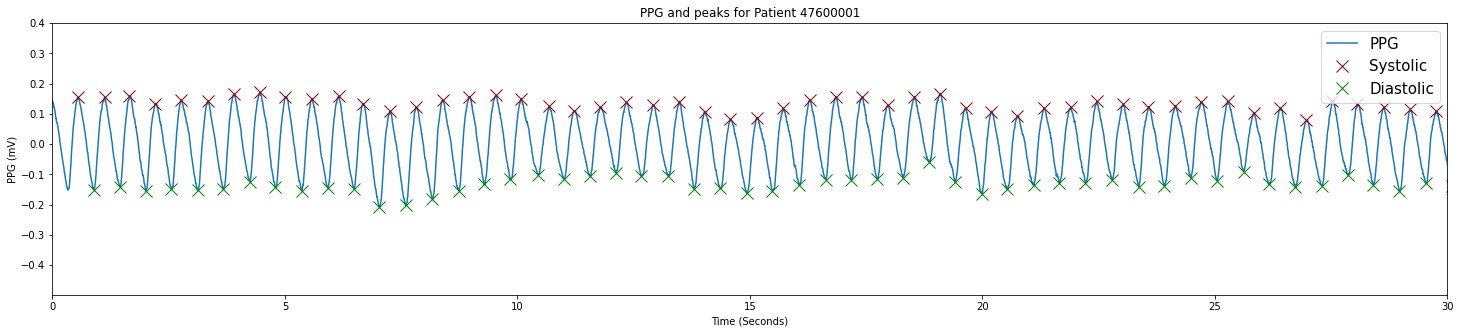

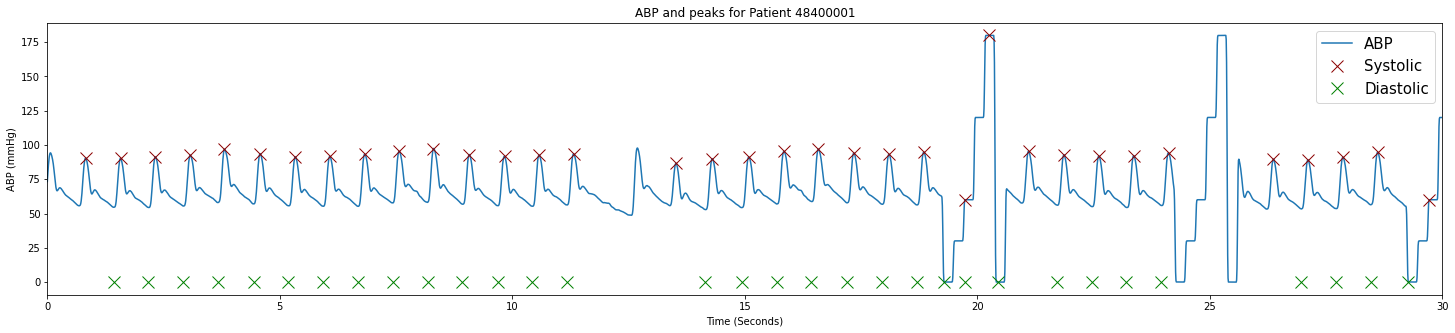

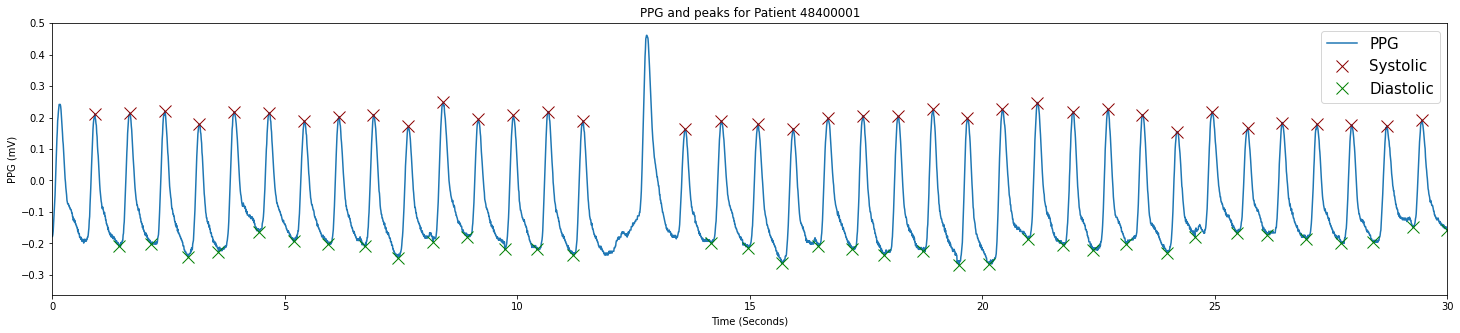

In [19]:
""" Download script for MIMIC-I data
Downloading the MIMIC I records, extracingt PPG and ABP data and performs peak detection on the
ABP (systolic and diastolic peaks of the ABP signals to generate systolic and diastolic blood pressure values as ground
truth) and PPG signals. ABP and PPG signals as well as the detected peaks are stored in .h5 files.
"""
# wfdb.get_dbs()

from os.path import expanduser, join, isdir
from os import mkdir
from itertools import compress
import datetime
#import warnings
#warnings.filterwarnings("error")

import wfdb
import numpy as np
import heartpy as hp
import h5py
import matplotlib.pyplot as plt

# helper function to find minima between two maxima
def find_minima(sig, pks, fs):
    min_pks = []
    for i in range(0,len(pks)):
        pks_curr = pks[i]
        if i == len(pks)-1:
            pks_next = len(sig)
        else:
            pks_next = pks[i+1]

        sig_win = sig[pks_curr:pks_next]
        # print(sig_win)
        if len(sig_win) < 1.5*fs:
          #  print(np.argmin(sig_win) + pks_curr)
            min_pks.append(np.argmin(sig_win) + pks_curr)

    return min_pks

def download_mimic_records(RecordsFile, OutputPath):

    # load record names from text file
    with open(RecordsFile, 'r') as f:
        RecordFiles = f.read()
        RecordFiles = RecordFiles.split("\n")
        RecordFiles = RecordFiles[:-1]

    abpSys = []
    ppgSys = []

    k = 1

    for file in RecordFiles:

        i = 1
        print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}: Processing record {file}')

        if i < 10:
          fileName = "{0}0000{1}".format(file, i)
        elif i < 100:
          fileName = "{0}000{1}".format(file, i)
        else:
          fileName = "{0}00{1}".format(file, i)

      #  print(fileName)
        # download record
        record = wfdb.rdrecord(fileName, pn_dir='mimicdb/' + file + '/')
      #  record = wfdb.rdrecord(file.split('/')[1], pn_dir='mimic3wdb/' + file.split('_')[0])

        # i = i + 1  

        # check, if ABP and PLETH are present in the record. If not, continue with next record
        if 'PLETH' in record.sig_name:
            pleth_idx = record.sig_name.index('PLETH')
            ppg = record.p_signal[:,pleth_idx]
            fs = record.fs
            # print(ppg)
            recordTemp1 = wfdb.rdrecord(fileName, pn_dir='mimicdb/' + file + '/',  channels = [record.sig_name.index('PLETH')])  # sampfrom=0, sampto=7200,
            # recordTemp = wfdb.rdrecord(file.split('/')[1], pn_dir='mimic3wdb/' + file.split('_')[0], channels = [record.sig_name.index('PLETH')])
            # print(recordTemp)       
            # wfdb.plot_wfdb(record=recordTemp, plot_sym='true', time_units='seconds', figsize=(25,5), title = 'PPG for Patient ' + fileName) 
            # display(recordTemp.__dict__['p_signal'])
        else:
            continue
    
        if 'ABP' in record.sig_name:
            abp_idx = record.sig_name.index('ABP')
            abp = record.p_signal[:,abp_idx]
            recordTemp2 = wfdb.rdrecord(fileName, pn_dir='mimicdb/' + file + '/',  channels = [record.sig_name.index('ABP')]) # sampfrom=0, sampto=7200,
            # recordTemp = wfdb.rdrecord(file.split('/')[1], pn_dir='mimic3wdb/' + file.split('_')[0], channels = [record.sig_name.index('ABP')])

            # print(recordTemp)       
            # wfdb.plot_wfdb(record=recordTemp2, plot_sym='true', time_units='seconds', figsize=(25,5), title = 'ABP for Patient ' + fileName) 
            # display(recordTemp.__dict__['p_signal'])
        else:
            continue

        # detect systolic and diastolic peaks using heartpy
        try:
            abp_FidPoints = hp.process(abp, fs)
            # abp_FidPoints = hp.process_segmentwise(abp, fs, segment_width=120)
            # wfdb.plot_wfdb(record=recordTemp2, plot_sym='true', time_units='seconds', figsize=(25,5), title = 'ABP for Patient ' + fileName) 
            # print('ABP Values', abp_FidPoints)
        except hp.exceptions.BadSignalWarning:
            continue

        ValidPks = abp_FidPoints[0]['binary_peaklist']
        abp_sys_pks = abp_FidPoints[0]['peaklist']
       # print(abp_sys_pks)
        abp_sys_pks = list(compress(abp_sys_pks, ValidPks == 1))
        abp_dia_pks = find_minima(abp, abp_sys_pks, fs)


        try:
          ppg_FidPoints = hp.process(ppg, fs)
          #   ppg_FidPoints = hp.process_segmentwise(ppg, fs, segment_width=120)
        #    wfdb.plot_wfdb(record=recordTemp1, plot_sym='true', time_units='seconds', figsize=(25,5), title = 'PPG for Patient ' + fileName) 
        #    print('PPG Values', abp_FidPoints)
        except hp.exceptions.BadSignalWarning:
            continue

        ValidPks = ppg_FidPoints[0]['binary_peaklist']
        ppg_pks = ppg_FidPoints[0]['peaklist']
        ppg_pks = list(compress(ppg_pks, ValidPks == 1))
        ppg_onset_pks = find_minima(ppg, ppg_pks, fs)

        x1a = np.linspace(0, len(abp)- 1, len(abp))
        x1a /= fs
        plt.figure(k, figsize=(25, 5))
        plt.plot(x1a, abp)
        plt.plot((np.asarray(abp_sys_pks))/fs, abp[(np.asarray(abp_sys_pks))], 'rx', marker='x', color='#8b0000', label='Systolic', markersize=12)   # np.asarray(abp_sys_pks)
        plt.plot((np.asarray(abp_dia_pks))/fs, ppg[(np.asarray(abp_dia_pks))], 'rx', marker='x', color='g', label='Diastolic', markersize=12)
        plt.xlim(0.0, 30.0)
        plt.title('ABP and peaks for Patient ' + fileName)
        plt.xlabel("Time (Seconds)")
        plt.ylabel("ABP (mmHg)")
        plt.legend(['ABP', 'Systolic', 'Diastolic'], loc='upper right', fontsize=15)        
        x2a = np.linspace(0, len(ppg)- 1, len(ppg))
        x2a /= fs      
        k = k + 1
        plt.figure(k, figsize=(25, 5))
        plt.plot(x2a, ppg)
        plt.plot((np.asarray(ppg_pks))/fs, ppg[(np.asarray(ppg_pks))], 'rx', marker='x', color='#8b0000', label='Systolic', markersize=12)
        plt.plot((np.asarray(ppg_onset_pks))/fs, ppg[(np.asarray(ppg_onset_pks))], 'rx', marker='x', color='g', label='Diastolic', markersize=12)
        plt.xlim(0.0, 30.0)
        plt.title('PPG and peaks for Patient ' + fileName)
        plt.xlabel("Time (Seconds)")
        plt.ylabel("PPG (mV)")
        plt.legend(['PPG', 'Systolic', 'Diastolic'], loc='upper right', fontsize=15)
        k = k + 1

        # save ABP and PPG signals as well as detected peaks in a .h5 file
        SubjectName = fileName
        SubjectFolder = join(join(OutputPath, SubjectName))
        if not isdir(SubjectFolder):
            mkdir(SubjectFolder)
        
        abpSys.append(np.array(abp_sys_pks))
        ppgSys.append(np.array(ppg_pks))

        with h5py.File(join(SubjectFolder, fileName + ".h5"),'w') as f:
            signals = np.concatenate((abp[:,np.newaxis],ppg[:,np.newaxis]), axis=1)
            f.create_dataset('val', signals.shape, data=signals)
            f.create_dataset('nB2', (1,len(ppg_onset_pks)), data=ppg_onset_pks)
            f.create_dataset('nA2', (1,len(ppg_pks)), data=ppg_pks)
            f.create_dataset('nB3', (1,len(abp_dia_pks)), data=abp_dia_pks)
            f.create_dataset('nA3', (1,len(abp_sys_pks)), data=abp_sys_pks)
    
    abpSys = np.array(abpSys)
    ppgSys = np.array(ppgSys)

   # print(abpSys.shape)
   # print(ppgSys.shape)
    print('script finished')

    return abpSys, ppgSys

if __name__ == '__main__':
    RecordsFile = '/content/drive/MyDrive/MIMIC_ppg_dataset_records.txt'
    OutputPath = '/content/drive/MyDrive/Colab Notebooks/Files'
    abp, ppg = download_mimic_records(RecordsFile, OutputPath)
    # print(abp[0,0])

In [24]:
import numpy as np
num_pat = ppg.shape[0]
max_arr = 0
amount_of_data = 0 
FSamp = 10

window_len = 10*FSamp

for i in ppg:
  # print(len(i))
  amount_of_data += len(i)//window_len

all_X = np.zeros((amount_of_data,window_len))
all_Y = np.zeros((amount_of_data,)) 

counter = 0

for ind, i in enumerate(ppg):
  for j in range(0,len(i)//window_len):
    all_X[counter] = i[j*window_len:(j+1)*window_len]
    BP_end = min(len(abp[ind]),(j+1)*window_len)
    all_Y[counter] = np.mean(abp[ind][j*window_len:BP_end])
    counter+=1

# all_X = all_X.reshape(-1,1)

k = 1
for i in range(0, all_X.shape[0]):
  X = all_X[i]
  Y = np.ones_like(X)*all_Y[i]  
  plt.figure(k, figsize=(25, 5))
  plt.plot(X);
  plt.figure(k+1,figsize=(25, 5))
  plt.scatter(Y);
  k += 1

TypeError: ignored

Error in callback <function flush_figures at 0x7fd952191ef0> (for post_execute):


KeyboardInterrupt: ignored

# Preparing the MIMIC I dataset

In [ ]:
"""
Preprocesses the downloaded PPG data. ABP and PPG signals are divided into windows of a defined length and
overlap. Ground truth SBP and DBP values are extracted from the ABP signals. PPG signals are filtered. Different
plausibility and sanity checks are performed to exclude artifacts from the dataset. PPG signal windows and associated
SBP/DBP value pairs are stored in a .h5 file.
"""

from os.path import join, expanduser, isfile, splitext
from os import listdir, scandir
from random import shuffle
import datetime

import h5py
import numpy as np
from scipy.signal import butter, freqs, filtfilt
from sklearn.covariance import EllipticEnvelope

def CreateWindows(win_len, fs, N_samp, overlap):
    win_len = win_len * fs
    overlap = np.round(overlap*win_len)
    N_samp = N_samp - win_len + 1

    idx_start = np.round(np.arange(0,N_samp, win_len-overlap)).astype(int)
    idx_stop = np.round(idx_start + win_len - 1)

    return idx_start, idx_stop

def prepare_MIMIC_dataset(DataPath, OutputFile, NsampPerSubMax:int=None, NsampMax:int=None, win_len:int=7, win_overlap:float=0.5, savePPGData=False):

    if savePPGData == False:
        print("Saving BP data only")
    else:
        print("saving PPG data")

    RecordsFile = splitext(OutputFile)[0] + '_records.txt'
    SubjectDirs = scandir(DataPath)
    NumSubjects = sum(1 for x in SubjectDirs)
    SubjectDirs = scandir(DataPath)

    fs = 125

    SBP_min = 40;
    SBP_max = 200;
    DBP_min = 40;
    DBP_max = 120;

    # 4th order butterworth filter for PPG preprcessing
    b,a = butter(4,[0.5, 8], 'bandpass', fs=fs)

    # if output file does not exist already, create it
    if not isfile(OutputFile):
        with h5py.File(OutputFile, "a") as f:
            if savePPGData:
                f.create_dataset('ppg', (0,win_len*fs), maxshape=(None,win_len*fs), chunks=(100, win_len*fs))
            f.create_dataset('label', (0,2), maxshape=(None,2), dtype=int, chunks=(100,2))
            f.create_dataset('subject_idx', (0,1), maxshape=(None,1), dtype=int, chunks=(100,1))

        with open(RecordsFile,'w') as f:
            pass

    # loop over all subjects and their files in the source folder
    subjectID = 0
    for idx, dirs in enumerate(SubjectDirs):
        print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}: Processing subject {idx+1} of {NumSubjects} ({dirs.name}): ', end='')

        PPG_RECORD = np.empty((0, win_len * fs))
        OUTPUT = np.empty((0, 2))

        DataFiles = [f for f in listdir(join(DataPath,dirs)) if isfile(join(DataPath, dirs,f)) and f.endswith('.h5')]
        shuffle(DataFiles)

        N_samp_total = 0
        for file in DataFiles:
            try:
                with h5py.File(join(DataPath, dirs, file), "r") as f:
                    data = {}
                    for key in f.keys():
                        data[key] = np.array(f[key]).transpose()
            except TypeError:
                print("could not read file. Skipping.")
            if savePPGData:
                PPG = data['val'][1, :]

            ABP = data['val'][0, :]

            if 'nB2' not in data:
                continue

            sys_p = data['nA2']


            ABP_sys_idx = data['nA3']-1
            ABP_dia_idx = data['nB3']-1

            # create start and stop indizes for time windows
            N_samples = ABP.shape[0]
            win_start, win_stop = CreateWindows(win_len, fs, N_samples, win_overlap)
            N_win = len(win_start)
            N_samp_total += N_win

            if savePPGData:
                ppg_record = np.zeros((N_win, win_len*fs))

            output = np.zeros((N_win, 2))

            # loop over windows
            for i in range(0, N_win):
                idx_start = win_start[i]
                idx_stop = win_stop[i]

                # extract peak idx of the current windows and the corresponding ABP signal values
                peak_idx = np.where(np.logical_and(sys_p >= idx_start, sys_p < idx_stop))
                sys_p_win = sys_p[peak_idx]
                N_sys_p = len(sys_p_win)

                # check if HR is in a plausible range
                if N_sys_p < (win_len/60)*40 or N_sys_p > (win_len/60)*120:
                    output[i,:] = np.nan
                    continue

                if savePPGData:
                    ppg_win = PPG[idx_start:idx_stop+1]

                # extract ABP window and fiducial points systolic and diastolic blood pressure
                abp_win = ABP[idx_start:idx_stop+1]

                # sanity check if enough peak values are present and if the number of SBP peaks matches the number of
                # DBP peaks
                ABP_sys_idx_win = ABP_sys_idx[np.logical_and(ABP_sys_idx >= idx_start, ABP_sys_idx < idx_stop)].astype(int)
                ABP_dia_idx_win = ABP_dia_idx[np.logical_and(ABP_dia_idx >= idx_start, ABP_dia_idx < idx_stop)].astype(int)

                if ABP_sys_idx_win.shape[-1] < (win_len/60)*40 or ABP_sys_idx_win.shape[-1] > (win_len/60)*120:
                    output[i, :] = np.nan
                    continue

                if ABP_dia_idx_win.shape[-1] < (win_len/60)*40 or ABP_dia_idx_win.shape[-1] > (win_len/60)*120:
                    output[i, :] = np.nan
                    continue

                if len(ABP_sys_idx_win) != len(ABP_dia_idx_win):
                    if ABP_sys_idx_win[0] > ABP_dia_idx_win[0]:
                        ABP_dia_idx_win = np.delete(ABP_dia_idx_win,0)
                    if ABP_sys_idx_win[-1] > ABP_dia_idx_win[-1]:
                        ABP_sys_idx_win = np.delete(ABP_sys_idx_win,-1)

                ABP_sys_win = ABP[ABP_sys_idx_win]
                ABP_dia_win = ABP[ABP_dia_idx_win]

                # check for NaN in ppg_win and abp_win
                if np.any(np.isnan(abp_win)):
                    output[i, :] = np.nan
                    continue

                if savePPGData:
                    if np.any(np.isnan(ppg_win)):
                        output[i, :] = np.nan
                        continue

                NN = np.diff(sys_p_win)/fs
                HR = 60/np.mean(NN)
                if HR < 50 or HR > 140:
                    output[i, :] = np.nan
                    continue

                # check for unreasonably large or small RR intervalls
                if np.any(NN < 0.3) or np.any(NN > 1.4):
                    output[i, :] = np.nan
                    continue

                # check if any of the SBP or DBP values exceed reasonable vlaues
                if np.any(np.logical_or(ABP_sys_win < SBP_min, ABP_sys_win > SBP_max)):
                    output[i, :] = np.nan
                    continue

                if np.any(np.logical_or(ABP_dia_win < DBP_min, ABP_dia_win > DBP_max)):
                    output[i, :] = np.nan
                    continue

                # check for NaN in the detected SBP and DBP peaks
                if np.any(np.isnan(ABP_sys_win)) or np.any(np.isnan(ABP_dia_win)):
                    output[i, :] = np.nan
                    continue

                # calculate the BP ground truth as the median of all SBP and DBP values in the present window
                BP_sys = np.median(ABP_sys_win).astype(int)
                BP_dia = np.median(ABP_dia_win).astype(int)

                # filter the ppg window using a 4th order Butterworth filter
                if savePPGData:
                    ppg_win = filtfilt(b,a, ppg_win)
                    ppg_win = ppg_win - np.mean(ppg_win)
                    ppg_win = ppg_win/np.std(ppg_win)
                    ppg_record[i, :] = ppg_win

                output[i,:] = [BP_sys, BP_dia]

                # if number of good samples (not NaN) exceeds maximum number of samples, stop extracting data
                N_nonNaN = np.count_nonzero(np.isnan(output[0:i+1,0]) == False)
                if NsampPerSubMax is not None:
                    if OUTPUT.shape[0] + N_nonNaN > 20*NsampPerSubMax:
                        output = np.delete(output,range(i,output.shape[0]), axis=0)

                        if savePPGData:
                            ppg_record = np.delete(ppg_record, range(i,ppg_record.shape[0]), axis=0)

                        break

            idx_nans = np.isnan(output[:,0])
            OUTPUT = np.vstack((OUTPUT, output[np.invert(idx_nans),:]))

            if savePPGData:
                PPG_RECORD = np.vstack((PPG_RECORD, ppg_record[np.invert(idx_nans),:]))

            # write record name to txt file for reproducibility
            with open(RecordsFile, 'a') as f:
                f.write(file[0:2] + "/" + file[0:-5]+"\n")

            if NsampPerSubMax is not None:
                if OUTPUT.shape[0] >= 20*NsampPerSubMax:
                    break

        if N_samp_total == 0:
            print(f'skipping')
            continue

        # save data is at least 100 good samples have been extracted
        if OUTPUT.shape[0] > 100:
            if NsampPerSubMax is not None:
                # if maximum number of samples per subject is defined, draw samples randomly
                if OUTPUT.shape[0] > NsampPerSubMax:
                    idx_select = np.random.choice(OUTPUT.shape[0]-1, size=(int(NsampPerSubMax)), replace=False)

                    if savePPGData:
                        PPG_RECORD = PPG_RECORD[idx_select,:]

                    OUTPUT = OUTPUT[idx_select,:]

            # add data to .h5 file
            with h5py.File(OutputFile, "a") as f:

                BP_dataset = f['label']
                DatasetCurrLength = BP_dataset.shape[0]
                DatasetNewLength = DatasetCurrLength + OUTPUT.shape[0]
                BP_dataset.resize(DatasetNewLength, axis=0)
                BP_dataset[-OUTPUT.shape[0]:,:] = OUTPUT

                if savePPGData:
                    ppg_dataset = f['ppg']

                    ppg_dataset.resize(DatasetNewLength, axis=0)
                    ppg_dataset[-PPG_RECORD.shape[0]:,:] = PPG_RECORD

                subject_dataset = f['subject_idx']
                subject_dataset.resize(DatasetNewLength, axis=0)
                subject_dataset[-OUTPUT.shape[0]:,:] = subjectID * np.ones((OUTPUT.shape[0], 1))

                print(f'{OUTPUT.shape[0]} samples ({DatasetNewLength} samples total)')
                if NsampMax is not None:
                    if f['label'].shape[0] > NsampMax:
                        return 0

        else:
            print(f'skipping')

        subjectID += 1

    print("script finished")

    return 0

  
if __name__ == "__main__":
    np.random.seed(seed=42)
    DataPath = '/content/drive/MyDrive/Colab Notebooks/Files'
    OutputFile = '/content/drive/MyDrive/Colab Notebooks/FilesTF'
    win_len = 7
    win_overlap = 0.5
    NsampPerSubMax = None
    NsampMax = None
    savePPGData = 0
    if savePPGData == 0:
        savePPGData = False
    else:
        savePPGData = True

    prepare_MIMIC_dataset(DataPath, OutputFile, NsampPerSubMax=NsampPerSubMax, NsampMax=NsampMax,
                          savePPGData=savePPGData, win_len=win_len, win_overlap=win_overlap)

# Converting from .h5 to Tensorflow format

In [ ]:
"""
This script reads a dataset consisting of PPG and BP samples from a .h5 file and converts them into a binary format that
can be used for as input data for a neural network during training. The dataset can be divided into training, validation
and test set by (i) dividing the dataset on a subject basis ensuring that data from one subject are not scattered across
training, validation and test set or (ii) dividing the dataset randomly.
"""

import matplotlib.pyplot as plt
import pandas as pd
import h5py
import tensorflow as tf
# ks.enable_eager_execution()
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
from os.path import expanduser, isdir, join
from os import mkdir

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _bytes_feature(value):
    #    if isinstance(value, type(ks.constant(0))):
    #        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


# def ppg_hdf2tfrecord(h5_file, tfrecord_path, samp_idx, weights_SBP=None, weights_DBP=None):
#     # Function that converts PPG/BP sample pairs into the binary .tfrecord file format. This function creates a .tfrecord
#     # file containing a defined number os samples
#     #
#     # Parameters:
#     # h5_file: file containing ppg and BP data
#     # tfrecordpath: full path for storing the .tfrecord files
#     # samp_idx: sample indizes of the data in the .h5 file to be stored in the .tfrecord file
#     # weights_SBP: sample weights for the systolic BP (optional)
#     # weights_DBP: sample weights for the diastolic BP (optional)

#     N_samples = len(samp_idx)
#     # open the .h5 file and get the samples with the indizes specified by samp_idx
#     with h5py.File(h5_file, 'r') as f:
#         # load ppg and BP data as well as the subject numbers the samples belong to
#         ppg_h5 = f.get('/ppg')
#         BP = f.get('/label')
#         subject_idx = f.get('/subject_idx')

#         writer = tf.io.TFRecordWriter(tfrecord_path)

#         # iterate over each sample index and convert the corresponding data to a binary format
#         for i in np.nditer(samp_idx):
#           if ppg_h5 != None:
#             ppg = np.array(ppg_h5[i,:])

#             if weights_SBP is not None and weights_DBP is not None:
#                 weight_SBP = weights_SBP[i]
#                 weight_DBP = weights_DBP[i]
#             else:
#                 weight_SBP = 1
#                 weight_DBP = 1

#             target = np.array(BP[i,:], dtype=np.float32)
#             sub_idx = np.array(subject_idx[i])

#             # create a dictionary containing the serialized data
#             data = \
#                 {'ppg': _float_feature(ppg.tolist()),
#                  'label': _float_feature(target.tolist()),
#                  'subject_idx': _float_feature(sub_idx.tolist()),
#                  'weight_SBP': _float_feature([weight_SBP]),
#                  'weight_DBP': _float_feature([weight_DBP]),
#                  'Nsamples': _float_feature([N_samples])}

#             # write data to the .tfrecord target file
#             feature = tf.train.Features(feature=data)
#             example = tf.train.Example(features=feature)
#             serialized = example.SerializeToString()

#             writer.write(serialized)

#             writer.close()

def ppg_hdf2tfrecord(h5_file, tfrecord_path, samp_idx, weights_SBP=None, weights_DBP=None):
    # Function that converts PPG/BP sample pairs into the binary .tfrecord file format. This function creates a .tfrecord
    # file containing a defined number os samples
    #
    # Parameters:
    # h5_file: file containing ppg and BP data
    # tfrecordpath: full path for storing the .tfrecord files
    # samp_idx: sample indizes of the data in the .h5 file to be stored in the .tfrecord file
    # weights_SBP: sample weights for the systolic BP (optional)
    # weights_DBP: sample weights for the diastolic BP (optional)

    N_samples = len(samp_idx)

    X_train = []
    Y_train = []
    # open the .h5 file and get the samples with the indizes specified by samp_idx
    with h5py.File(h5_file, 'r') as f:
        # load ppg and BP data as well as the subject numbers the samples belong to
        ppg_h5 = f.get('/ppg')
        BP = f.get('/label')
        print(BP)
        subject_idx = f.get('/subject_idx')

        writer = tf.io.TFRecordWriter(tfrecord_path)

        # iterate over each sample index and convert the corresponding data to a binary format
        for i in np.nditer(samp_idx):
         # print(i)
         # print(ppg_h5)
          if ppg_h5 != None:
            ppg = np.array(ppg_h5[i,:])

            if weights_SBP is not None and weights_DBP is not None:
                weight_SBP = weights_SBP[i]
                weight_DBP = weights_DBP[i]
            else:
                weight_SBP = 1
                weight_DBP = 1

            target = np.array(BP[i,:], dtype=np.float32)
            sub_idx = np.array(subject_idx[i])

            # create a dictionary containing the serialized data
            print('PPG: ',ppg.tolist())
            print('label: ',target.tolist())
            print('Nsamples: ',[N_samples])

            data = \
                {'ppg': _float_feature(ppg.tolist()),
                 'label': _float_feature(target.tolist()),
                 'subject_idx': _float_feature(sub_idx.tolist()),
                 'weight_SBP': _float_feature([weight_SBP]),
                 'weight_DBP': _float_feature([weight_DBP]),
                 'Nsamples': _float_feature([N_samples])}

            # write data to the .tfrecord target file
            feature = tf.train.Features(feature=data)
            example = tf.train.Example(features=feature)
            serialized = example.SerializeToString()

            writer.write(serialized)

            writer.close()

def ppg_hdf2tfrecord_sharded(h5_file, samp_idx, tfrecordpath, Nsamp_per_shard, modus='train', weights_SBP=None,
                         weights_DBP=None):
    # Save PPG/BP pairs as .tfrecord files. Save defined number os samples per file (Sharding)
    # Weights can be defined for each sample
    #
    # Parameters:
    # h5_file: File that contains the whole dataset (in .h5 format), created by
    # samp_idx: sample indizes from the dataset in the h5. file that are used to create this tfrecords dataset
    # tfrecordpath: full path for storing the .tfrecord files
    # N_samp_per_shard: number of samples per shard/.tfrecord file
    # modus: define if the data is stored in the "train", "val" or "test" subfolder of "tfrecordpath"
    # weights_SBP: sample weights for the systolic BP (optional)
    # weights_DBP: sample weights for the diastolic BP (optional)

    base_filename = join(tfrecordpath, 'MIMIC_III_ppg')

    N_samples = len(samp_idx)

    # calculate the number of Files/shards that are needed to stroe the whole dataset
    N_shards = np.ceil(N_samples / Nsamp_per_shard).astype(int)

    # iterate over every shard
    for i in range(N_shards):
        idx_start = i * Nsamp_per_shard
        idx_stop = (i + 1) * Nsamp_per_shard
        if idx_stop > N_samples:
            idx_stop = N_samples

        idx_curr = samp_idx[idx_start:idx_stop]
        output_filename = '{0}_{1}_{2:05d}_of_{3:05d}.tfrecord'.format(base_filename,
                                                                       modus,
                                                                       i + 1,
                                                                       N_shards)
        now = datetime.now()
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        print(dt_string, ': processing ',
              modus,
              ' shard ', str(i + 1), ' of ', str(N_shards))
        ppg_hdf2tfrecord(h5_file, output_filename, idx_curr, weights_SBP=weights_SBP, weights_DBP=weights_DBP)


def h5_to_tfrecords(SourceFile, tfrecordsPath, N_train=1e4, N_val=2.5e2, N_test=2.5e2,
                    divide_by_subject=True, save_tfrecords=False):
    N_train = int(N_train)
    N_val = int(N_val)
    N_test = int(N_test)

    tfrecord_path_train = join(tfrecordsPath, 'train')
    if not isdir(tfrecord_path_train):
        mkdir(tfrecord_path_train)
    tfrecord_path_val = join(tfrecordsPath, 'val')
    if not isdir(tfrecord_path_val):
        mkdir(tfrecord_path_val)
    tfrecord_path_test = join(tfrecordsPath, 'test')
    if not isdir(tfrecord_path_test):
        mkdir(tfrecord_path_test)

    csv_path = tfrecordsPath

    Nsamp_per_shard = 1000

    with h5py.File(SourceFile, 'r') as f:
        BP = np.array(f.get('/label'))
        BP = np.round(BP)
        BP = np.transpose(BP)
        subject_idx = np.squeeze(np.array(f.get('/subject_idx')))

    N_samp_total = BP.shape[1]
    subject_idx = subject_idx[:N_samp_total]

    # Divide the dataset into training, validation and test set
    # -------------------------------------------------------------------------------
    if divide_by_subject is True:
        valid_idx = np.arange(subject_idx.shape[-1])

        # divide the subjects into training, validation and test subjects
        subject_labels = np.unique(subject_idx)
        subjects_train_labels, subjects_val_labels = train_test_split(subject_labels, test_size=0.5)
        subjects_val_labels, subjects_test_labels = train_test_split(subjects_val_labels, test_size=0.5)

        # Calculate samples belong to training, validation and test subjects
        train_part = valid_idx[np.isin(subject_idx,subjects_train_labels)]
        val_part = valid_idx[np.isin(subject_idx,subjects_val_labels)]
        test_part = valid_idx[np.isin(subject_idx, subjects_test_labels)]

        #print("Training", train_part.size)
        #print("Val", val_part.size)
        #print("Test", test_part.size)

        N_train = train_part.size
        N_val = val_part.size
        N_test = test_part.size

        # draw a number samples defined by N_train, N_val and N_test from the training, validation and test subjects

        idx_train = np.random.choice(train_part, N_train, replace=False)
        idx_val = np.random.choice(val_part, N_val, replace=False)
        idx_test = np.random.choice(test_part, N_test, replace=False)
    else:
        # Create a subset of the whole dataset by drawing a number of subjects from the dataset. The total number of
        # samples contributed by those subjects must equal N_train + N_val + _N_test
        subject_labels, SampSubject_hist = np.unique(subject_idx, return_counts=True)
        cumsum_samp = np.cumsum(SampSubject_hist)
        subject_labels_train = subject_labels[:np.nonzero(cumsum_samp>(N_train+N_val+N_test))[0][0]]
        idx_valid = np.nonzero(np.isin(subject_idx,subject_labels_train))[0]

        # divide subset randomly into training, validation and test set
        idx_train, idx_val = train_test_split(idx_valid, train_size= N_train, test_size=N_val+N_test)
        idx_val, idx_test = train_test_split(idx_val, test_size=0.5)

    # save ground truth BP values of training, validation and test set in csv-files for future reference
    BP_train = BP[:,idx_train]
    d = {"SBP": np.transpose(BP_train[0, :]), "DBP": np.transpose(BP_train[1, :])}
    train_set = pd.DataFrame(d)
    train_set.to_csv(csv_path + 'MIMIC-III_BP_trainset.csv')
    BP_val = BP[:,idx_val]
    d = {"SBP": np.transpose(BP_val[0, :]), "DBP": np.transpose(BP_val[1, :])}
    train_set = pd.DataFrame(d)
    train_set.to_csv(csv_path + 'MIMIC-III_BP_valset.csv')
    BP_test = BP[:,idx_test]
    d = {"SBP": np.transpose(BP_test[0, :]), "DBP": np.transpose(BP_test[1, :])}
    train_set = pd.DataFrame(d)
    train_set.to_csv(csv_path + 'MIMIC-III_BP_testset.csv')

    # create tfrecord dataset
    # ----------------------------
    if save_tfrecords:
        np.random.shuffle(idx_train)
        ppg_hdf2tfrecord_sharded(SourceFile, idx_test, tfrecord_path_test, Nsamp_per_shard, modus='test')
        ppg_hdf2tfrecord_sharded(SourceFile, idx_train, tfrecord_path_train, Nsamp_per_shard, modus='train')
        ppg_hdf2tfrecord_sharded(SourceFile, idx_val, tfrecord_path_val, Nsamp_per_shard, modus='val')
    print("Script finished")

if __name__ == "__main__":
    np.random.seed(seed=42)

    divbysubj = 1

    if divbysubj == 1:
      divbysubj = True
    else:
      divbysubj = False

    SourceFile = '/content/drive/MyDrive/Colab Notebooks/FilesTF'
    tfrecordsPath = '/content/drive/MyDrive/Colab Notebooks/FilesUpdated'

    h5_to_tfrecords(SourceFile=SourceFile, tfrecordsPath=tfrecordsPath, divide_by_subject=divbysubj,
                        save_tfrecords=True)
    
    # N_train=1e4, N_val=2.5e2, N_test=2.5e2

# ARCHITECTURES

## ALEXNET

In [ ]:
from IPython.display import Image
display(Image('/content/drive/MyDrive/Colab Notebooks/alexnet.png'))

In [5]:
# Implements an AlexNet Conv-Net which performs HR, SBP and DBP regression based
# on spectrograms. The net's input are ppg time series.
#
# Arguments:
# data_in : Tensor containing the rppg time series. Size (batch_size, ppg_length, 1)
# fs : sampling frequency (default fs = 125 Hz)
# frame_len : length of the STFFT in seconds (default frame_len = 10)
# n_hop : length between frames during spectrogram calculation in samples (default n_hop = 1)
#
# A. Krizhevsky, I. Sutskever, und G. E. Hinton, „ImageNet classification with deep convolutional neural networks“,
# Commun. ACM, Bd. 60, Nr. 6, S. 84–90, Mai 2017, doi: 10.1145/3065386.
#

from tensorflow.keras.layers import Softmax, Permute, Input, Add, Conv1D, MaxPooling1D, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling1D, MaxPooling2D, GlobalMaxPooling2D, LeakyReLU, GlobalAveragePooling2D, ReLU, Dropout
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
import tensorflow as tf

def AlexNet_1D(data_in_shape, num_output=2, dil=1, kernel_size=3, fs = 10, useMaxPooling=True, UseDerivative=False):

    # Define the input as a tensor with shape input_shape
    X_input = Input(shape=data_in_shape)

    if UseDerivative:
        dt1 = (X_input[:,1:] - X_input[:,:-1])*fs
        dt2 = (dt1[:,1:] - dt1[:,:-1])*fs

        dt1 = tf.pad(dt1, tf.constant([[0,0],[0,1],[0,0]]))
        dt2 = tf.pad(dt2, tf.constant([[0,0],[0,2],[0,0]]))

        X = tf.concat([X_input, dt1, dt2], axis=2)
    else:
        X=X_input


    # convolutional stage
    X = Conv1D(96, 7, strides=3, name='conv1', kernel_initializer=glorot_uniform(seed=0), padding="same")(X)
    if useMaxPooling:
        X = MaxPooling1D(3, strides=2, name="MaxPool1")(X)
    X = Activation(ReLU())(X)
    X = BatchNormalization(axis=-1, name='BatchNorm1')(X)

    X = Conv1D(256, kernel_size=kernel_size, strides=1, dilation_rate=dil, name='conv2', kernel_initializer=glorot_uniform(seed=0), padding="same")(X)
    if useMaxPooling:
        X = MaxPooling1D(3, strides=2, name="MaxPool2")(X)
    X = Activation(ReLU())(X)
    X = BatchNormalization(axis=-1, name='BatchNorm2')(X)

    X = Conv1D(384, kernel_size=kernel_size, strides=1, dilation_rate=dil, name='conv3', kernel_initializer=glorot_uniform(seed=0), padding="same")(X)
    X = Activation(ReLU())(X)
    X = BatchNormalization(axis=-1, name='BatchNorm3')(X)

    X = Conv1D(384, kernel_size=kernel_size, strides=1, dilation_rate=dil, name='conv4', kernel_initializer=glorot_uniform(seed=0), padding="same")(X)
    X = Activation(ReLU())(X)
    X = BatchNormalization(axis=-1, name='BatchNorm4')(X)

    X = Conv1D(256, kernel_size=kernel_size, strides=1, dilation_rate=dil, name='conv5', kernel_initializer=glorot_uniform(seed=0), padding="same")(X)
    if useMaxPooling:
        X = MaxPooling1D(3, strides=2, name="MaxPool5")(X)
    X = Activation(ReLU())(X)
    X = BatchNormalization(axis=-1, name='BatchNorm5')(X)

    # Fully connected stage
    X = Flatten()(X)
    X = Dense(4096, activation='relu', name='dense1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dropout(rate=0.5)(X)
    X = Dense(4096, activation='relu', name='dense2', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dropout(rate=0.5)(X)

    # Create model
    if num_output == 1:
        X_out = Dense(3, activation='softmax', name='out', kernel_initializer=glorot_uniform(seed=0))(X)
        model = Model(inputs=X_input, outputs=X_out, name='AlexNet_1D')
    else:
        # output stage
        X_SBP = Dense(1, activation='relu', name='SBP', kernel_initializer=glorot_uniform(seed=0))(X)
        X_DBP = Dense(1, activation='relu', name='DBP', kernel_initializer=glorot_uniform(seed=0))(X)
        model = Model(inputs=X_input, outputs=[X_SBP, X_DBP], name='AlexNet_1D')

    return model

## RESNET

In [ ]:
display(Image('/content/drive/MyDrive/Colab Notebooks/resnet.png'))

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv1D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling2D, LeakyReLU, GlobalAveragePooling2D, ReLU, concatenate
from tensorflow.keras.initializers import glorot_uniform, constant
from tensorflow.keras.models import Model
import tensorflow as tf


def identity_block(X, f, filters, stage, block, dil=1):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv1D(filters = F1, kernel_size = 1, strides = 1, dilation_rate=dil, padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum = 0.9, name = bn_name_base + '2a')(X)
    X = Activation(ReLU())(X)

    # Second component of main path (≈3 lines)
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, dilation_rate=dil, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum=0.9, name=bn_name_base + '2b')(X)
    X = Activation(ReLU())(X)

    # Third component of main path (≈2 lines)
    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, dilation_rate=dil, padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum = 0.9, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation(ReLU())(X)
    # X = BatchNormalization(momentum = 0.9, name = bn_name_base + '2c')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2, dil = 1):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv1D(F1, 1, strides = s, name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum=0.9, name=bn_name_base + '2a')(X)
    X = Activation(ReLU())(X)
    
    # Second component of main path (≈3 lines)
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, dilation_rate=dil, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum=0.9, name=bn_name_base + '2b')(X)
    X = Activation(ReLU())(X)

    # Third component of main path (≈2 lines)
    X = Conv1D(filters = F3, kernel_size = 1, dilation_rate=dil, strides = 1, padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum = 0.9, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv1D(filters = F3, kernel_size = 1, strides = s, padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization( momentum = 0.9, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation(ReLU())(X)
    # X = BatchNormalization(momentum = 0.9, name = bn_name_base + '2c')(X)
    
    return X

def ResNet50_1D(data_in_shape, num_output=2, fs=125, UseDerivative=False):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(shape=data_in_shape)

    if UseDerivative:
        dt1 = (X_input[:,1:] - X_input[:,:-1])*fs
        dt2 = (dt1[:,1:] - dt1[:,:-1])*fs

        dt1 = tf.pad(dt1, tf.constant([[0,0],[0,1],[0,0]]))
        dt2 = tf.pad(dt2, tf.constant([[0,0],[0,2],[0,0]]))

        X = tf.concat([X_input, dt1, dt2], axis=2)
    else:
        X=X_input

    # Zero-Padding
    X = ZeroPadding1D(3)(X_input)

    # Stage 1
    X = Conv1D(64, 7, strides=2, name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides=3)(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling1D(2, name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X_SBP = Dense(1, activation='linear', name='SBP', kernel_initializer = glorot_uniform(seed=0))(X)
    X_DBP = Dense(1, activation='linear', name='DBP', kernel_initializer = glorot_uniform(seed=0))(X)
    HR = Dense(1, activation='linear', name='HR', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    if num_output==3:
        model = Model(inputs=X_input, outputs=[X_SBP, X_DBP, HR], name='ResNet50_1D')
    else:
        model = Model(inputs = X_input, outputs = [X_SBP, X_DBP], name='ResNet50_1D')

    return model

## Slapnicar

In [ ]:
display(Image('/content/drive/MyDrive/Colab Notebooks/slapnicar.png'))

In [7]:
from __future__ import division, print_function
import numpy as np
np.random.seed(3)
import os

from scipy.signal import butter, lfilter, lfilter_zi, filtfilt, savgol_filter
from sklearn.preprocessing import MinMaxScaler
import sklearn as sk
import random
random.seed(3)

import scipy.io as sio
import matplotlib.pyplot as plt
import natsort as natsort
from scipy import signal
import math

import tensorflow as tf
# from tensorflow.keras.utils import multi_gpu_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import squeeze
from kapre import STFT, Magnitude, MagnitudeToDecibel
# from kapre.utils import Normalization2D
from tensorflow.keras.layers import Input, BatchNormalization, Lambda, AveragePooling2D, Flatten, Dense, Conv1D, Activation, add, AveragePooling1D, Dropout, Permute, concatenate, MaxPooling1D, LSTM, Reshape, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from tensorflow.keras import optimizers
#from tensorflow.keras.utils.vis_utils import plot_model

from tensorflow.keras.layers import Conv2D, MaxPooling2D

def diff(input, fs):
    dt = (input[:, 1:] - input[:, :-1]) * fs
    dt = tf.pad(dt, tf.constant([[0, 0], [0, 1], [0, 0]]))

    return dt

def mid_spectrogram_layer(input_x):
    l2_lambda = .001
    n_dft = 128
    n_hop = 64
    fmin = 0.0
    fmax = 50 / 2

    x = Permute((2, 1))(input_x)
    # x = input_x
    x = STFT(n_fft=n_dft, hop_length=n_hop, output_data_format='channels_last')(x)
    x = Magnitude()(x)
    #x = MagnitudeToDecibel()(x)
    #x = BatchNormalization()(x)
    # x = Normalization2D(str_axis='batch')(x)
    x = Flatten()(x)
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)

    return x


def mid_spectrogram_LSTM_layer(input_x):
    l2_lambda = .001
    n_dft = 64

    n_hop = 64
    fmin = 0.0
    fmax = 50 / 2

    #x = Permute((2, 1))(input_x)
    x = input_x
    x = STFT(n_fft=n_dft, hop_length=n_hop, output_data_format='channels_last')(x)
    x = Magnitude()(x)
    x = MagnitudeToDecibel()(x)
   #x = BatchNormalization()(x)
    # x = Normalization2D(str_axis='batch')(x)
    # print(np.array(x).shape)
    # x = Reshape((2, 64))(x)
    # x = GRU(64)(x)
    x = Flatten()(x)
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)

    return x


def single_channel_resnet(my_input, num_filters=64, num_res_blocks=4, cnn_per_res=3,
                          kernel_sizes=[8, 5, 3], max_filters=128, pool_size=3, pool_stride_size=2):

    #my_input = Input(shape=input_shape)
    # my_input = input_shape
    # my_input = ks.expand_dims(my_input, axis=2)

    for i in np.arange(num_res_blocks):
        if (i == 0):
            block_input = my_input
            x = BatchNormalization()(block_input)
        else:
            block_input = x

        for j in np.arange(cnn_per_res):
            x = Conv1D(num_filters, kernel_sizes[j], padding='same')(x)
            x = BatchNormalization()(x)
            if (j < cnn_per_res - 1):
                x = Activation('relu')(x)

        is_expand_channels = not (my_input.shape[0] == num_filters)

        if is_expand_channels:
            res_conn = Conv1D(num_filters, 1, padding='same')(block_input)
            res_conn = BatchNormalization()(res_conn)
        else:
            res_conn = BatchNormalization()(block_input)

        x = add([res_conn, x])
        x = Activation('relu')(x)

        if (i < 5):
            x = AveragePooling1D(pool_size=pool_size, strides=pool_stride_size)(x)

        num_filters = 2 * num_filters
        if max_filters < num_filters:
            num_filters = max_filters

    return my_input, x


def raw_signals_deep_ResNet(input, UseDerivative=False):
    fs=125

    inputs = []
    l2_lambda = .001
    channel_outputs = []
    num_filters = 32

    X_input = Input(shape=input)

    if UseDerivative:
        # fs = tf.constant(fs, dtype=float)
        X_dt1 = Lambda(diff, arguments={'fs': fs})(X_input)
        X_dt2 = Lambda(diff, arguments={'fs': fs})(X_dt1)
        X = [X_input, X_dt1, X_dt2]
    else:
        X = [X_input]

    num_channels = len(X)

    for i in np.arange(num_channels):
        channel_resnet_input, channel_resnet_out = single_channel_resnet(X[i], num_filters=num_filters,
                                                                     num_res_blocks=4, cnn_per_res=3,
                                                                     kernel_sizes=[8, 5, 5, 3],
                                                                     max_filters=64, pool_size=2, pool_stride_size=1)
        channel_outputs.append(channel_resnet_out)
        inputs.append(channel_resnet_input)

    spectral_outputs = []
    num_filters = 32
    for x in inputs:
        spectro_x = mid_spectrogram_LSTM_layer(x)
        spectral_outputs.append(spectro_x)

    # concateante the channel specific residual layers
    if num_channels > 1:
        x = concatenate(channel_outputs, axis=-1)
    else:
        x = channel_outputs[0]

    x = BatchNormalization()(x)
    x = GRU(65)(x)
    # x = Flatten()(x)
    x = BatchNormalization()(x)

    # join time-domain and frequnecy domain fully-conencted layers
    if num_channels > 1:
        s = concatenate(spectral_outputs, axis=-1)
    else:
        s = spectral_outputs[0]

    # s = Flatten()(s)
    #     x = Dense(128,activation="relu",kernel_regularizer=l2(l2_lambda)) (x)
    s = BatchNormalization()(s)
    # LETS DO OVERFIT
    x = concatenate([s, x])
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_lambda))(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_lambda))(x)
    x = Dropout(0.25)(x)
    #output = Dense(2, activation="relu")(x)
    x = Flatten()(x)
    X_SBP = Dense(1, activation='linear', name='SBP')(x)
    X_DBP = Dense(1, activation='linear', name='DBP')(x)

    model = Model(inputs=X_input, outputs=[X_SBP, X_DBP], name="Slapnicar_Model")
    # model = multi_gpu_model(model, gpus=2)
    # optimizer = optimizers.Adadelta()
    # loss = ks.keras.losses.mean_absolute_error
    # model.compile(optimizer=optimizer, loss=loss, metrics=['mae', 'mae'])
    print(model.summary())
    # plot_model(model=model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)
    return model


def one_chennel_resnet(input_shape,num_filters=16,num_res_blocks = 5,cnn_per_res = 3,
                        kernel_sizes = [3,3,3], max_filters = 64, pool_size = 3,
                        pool_stride_size = 2,num_classes=8):
    my_input  = Input(shape=(input_shape))
    for i in np.arange(num_res_blocks):
        if(i==0):
            block_input = my_input
            x = BatchNormalization()(block_input)
        else:
            block_input = x
        for j in np.arange(cnn_per_res):
            x = Conv1D(num_filters, kernel_sizes[j], padding='same')(x)
            x = BatchNormalization()(x)
            if(j<cnn_per_res-1):
                x = Activation('relu')(x)
        is_expand_channels = not (input_shape[0] == num_filters)
        if is_expand_channels:
            res_conn = Conv1D(num_filters, 1,padding='same')(block_input)
            res_conn = BatchNormalization()(res_conn)
        else:
            res_conn = BatchNormalization()(block_input)
        x = add([res_conn, x])
        x = Activation('relu')(x)
        if(i<5):
            x = MaxPooling1D(pool_size=pool_size,strides =pool_stride_size)(x)
        num_filters = 2*num_filters
        if max_filters<num_filters:
            num_filters = max_filters
    return my_input,x


def one_chennel_resnet_2D(input_shape, input_layer, num_filters=16,num_res_blocks = 5,cnn_per_res = 3,
                        kernel_sizes = [8, 5, 3], max_filters = 64, pool_size = (3,3),
                        pool_stride_size = 2, num_classes=8):
    kernel_sizes = [(8, 1), (5, 1), (3, 1)]
    my_input = input_layer
    for i in np.arange(num_res_blocks):
        if(i==0):
            block_input = my_input
            x = BatchNormalization()(block_input)
        else:
            block_input = x
        for j in np.arange(cnn_per_res):
            x = Conv2D(num_filters, kernel_sizes[j], padding='same')(x)
            x = BatchNormalization()(x)
            if(j<cnn_per_res-1):
                x = Activation('relu')(x)
        is_expand_channels = not (input_shape[0] == num_filters)
        if is_expand_channels:
            res_conn = Conv2D(num_filters, (1,1), padding='same')(block_input)
            res_conn = BatchNormalization()(res_conn)
        else:
            res_conn = BatchNormalization()(block_input)
        x = add([res_conn, x])
        x = Activation('relu')(x)
        if(i<5):
            x = MaxPooling2D(pool_size=pool_size,strides =pool_stride_size)(x)
        num_filters = 2*num_filters
        if max_filters<num_filters:
            num_filters = max_filters
    return my_input,x


def spectro_layer_mid(input_x,sampling_rate, ndft=0, num_classes=8):
    l2_lambda = .001
    if(ndft == 0):
        n_dft= 128
    else:
        n_dft = ndft
    # n_dft = 64
    n_hop = 64
    fmin=0.0
    fmax=sampling_rate//2

    x = Permute((2,1))(input_x)
    x = STFT(n_fft=n_dft, hop_length=n_hop, output_data_format='channels_last')(x)
    x = Magnitude()(x)
    #x = MagnitudeToDecibel()(x)
    #x = BatchNormalization()(x)    # x = Normalization2D(str_axis='batch')(x)
    channel_resnet_input,channel_resnet_out= one_chennel_resnet_2D((625, 1), x, num_filters=64,
                    num_res_blocks = 6,cnn_per_res = 3,kernel_sizes = [3,3,3,3],
                    max_filters = 32, pool_size = 1,
                    pool_stride_size =1,num_classes=8)
    channel_resnet_out = BatchNormalization()(channel_resnet_out)

    # x = Reshape((10, 65))(x)
    # x = GRU(65)(x)

    return channel_resnet_out


#  Class custom_callback is used logging data and other operations of the model while its in learning process.
class custom_callback(tf.keras.callbacks.Callback):
    model_name = ""
    path = ""
    best = 100

    def __init__(self, dir, model_name, treshold=25):
        self.model_name = model_name
        self.path = dir + model_name + "/"
        self.best = treshold

    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        # print(self.model.summary())
        return

    def on_train_end(self, logs={}):
        # n = np.arange(0, len(self.losses))
        # plt.figure()
        # plt.plot(n, self.losses, label="train_loss")
        # plt.plot(n, self.acc, label="train_acc")
        # plt.plot(n, self.val_losses, label="val_loss")
        # plt.plot(n, self.val_acc, label="val_acc")
        # plt.title("Training Loss and Acc")
        # plt.xlabel("Epochs")
        # plt.ylabel("Loss/Accuracy")
        # plt.legend()
        # plt.savefig(self.path + 'training_stats.png')
        # plt.close()
        # self.model.save(self.path + "model_arch.h5")
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs.get('mean_absolute_error'))
        self.val_acc.append(logs.get('val_mean_absolute_error'))
        if(logs.get('val_mean_absolute_error') < self.best):
            print("val_mean_absolute_error improved from " + str(self.best) + " to " + str(logs.get('val_mean_absolute_error')) + "...")
            self.best = logs.get('val_mean_absolute_error')
            self.model.save_weights("./Models/" + self.model_name + "_weights.h5")
        else:
            print("val_mean_absolute_error has not improved from " + str(self.best) + "...")


    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

## LSTM

In [ ]:
display(Image('/content/drive/MyDrive/Colab Notebooks/lstm.png'))

In [8]:
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Conv1D, ReLU

from tensorflow.keras import Model

def define_LSTM(data_in_shape):
    X_input = Input(shape=data_in_shape)
    X = Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu')(X_input)
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    X = Bidirectional(LSTM(64, return_sequences=False))(X)
    X = Dense(512, activation='relu')(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(128, activation='relu')(X)

    X_SBP = Dense(1, name='SBP')(X)
    X_DBP = Dense(1, name='DBP')(X)

    model = Model(inputs=X_input, outputs=[X_SBP, X_DBP], name='LSTM')

    return model

# Training using PPG data

In [ ]:
""" train neural architectures using PPG data
This script trains a neural network using PPG data. The data is loaded from the the .tfrecord files created by the script
'hdf_to_tfrecord.py'. Four different neural architectures can be selected:
- AlexNet [1]
- ResNet [2]
- Architecture published by Slapnicar et al. (modified to work with Tensorflow 2.4.1) [3] The original code can be downloaded
  from https://github.com/gslapnicar/bp-estimation-mimic3
- LSTM network
A checkpoint callback is used to store the best network weights in terms of validation loss. These weights are subsequently
used to perform predictions on the test set. Test results are stored in a csv file for later evaluation.
References
[1] A. Krizhevsky, I. Sutskever, und G. E. Hinton, „ImageNet classification with deep convolutional neural networks“,
    Commun. ACM, Bd. 60, Nr. 6, S. 84–90, Mai 2017, doi: 10.1145/3065386.
[2] K. He, X. Zhang, S. Ren, und J. Sun, „Deep Residual Learning for Image Recognition“, in 2016 IEEE Conference on
    Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Juni 2016, S. 770–778. doi: 10.1109/CVPR.2016.90.
[3] G. Slapničar, N. Mlakar, und M. Luštrek, „Blood Pressure Estimation from Photoplethysmogram Using a Spectro-Temporal
    Deep Neural Network“, Sensors, Bd. 19, Nr. 15, S. 3420, Aug. 2019, doi: 10.3390/s19153420.
"""

from os.path import expanduser, join
from os import environ
from functools import partial
from datetime import datetime

import tensorflow as tf
import pandas as pd
import numpy as np

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

def read_tfrecord(example, win_len=875):
    tfrecord_format = (
        {
            'ppg': tf.io.FixedLenFeature([win_len], tf.float32),
            'label': tf.io.FixedLenFeature([2], tf.float32)
        }
    )
    parsed_features = tf.io.parse_single_example(example, tfrecord_format)

    return parsed_features['ppg'], (parsed_features['label'][0], parsed_features['label'][1])

def create_dataset(tfrecords_dir, tfrecord_basename, epochs, win_len=875, batch_size=32, modus='train'):

    pattern = join(tfrecords_dir, modus, tfrecord_basename + "_" + modus + "_?????_of_?????.tfrecord")
    dataset = tf.data.TFRecordDataset.list_files(pattern)

    if modus == 'train':
        dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
        dataset = dataset.interleave(
            tf.data.TFRecordDataset,
            cycle_length=800,
            block_length=400)
    else:
        dataset = dataset.interleave(
            tf.data.TFRecordDataset)

    dataset = dataset.map(partial(read_tfrecord, win_len=win_len), num_parallel_calls=2)
    dataset = dataset.shuffle(4096, reshuffle_each_iteration=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.repeat(epochs)

    return dataset

def get_model(architecture, input_shape, UseDerivative=False):
    return {
        'alexnet': AlexNet_1D(input_shape, UseDerivative=UseDerivative),
    }[architecture]

       # 'resnet': ResNet50_1D(input_shape, UseDerivative=UseDerivative),
       # 'slapnicar' : raw_signals_deep_ResNet(input_shape, UseDerivative=UseDerivative),
       # 'lstm' : define_LSTM(input_shape)

def ppg_train_mimic_iii(architecture,
                        DataDir,
                        ResultsDir,
                        CheckpointDir,
                        tensorboard_tag,
                        tfrecord_basename,
                        experiment_name,
                        win_len=875,
                        batch_size=32,
                        lr = None,
                        N_epochs = 20,
                        Ntrain=1e6,
                        Nval=2.5e5,
                        Ntest=2.5e5,
                        UseDerivative=False,
                        earlystopping=True):

    # create datasets for training, validation and testing using .tfrecord files
    test_dataset = create_dataset(DataDir, tfrecord_basename, N_epochs, win_len=win_len, batch_size=batch_size,
                                  modus='test')
    train_dataset = create_dataset(DataDir, tfrecord_basename, N_epochs, win_len=win_len, batch_size=batch_size, modus='train')
    val_dataset = create_dataset(DataDir, tfrecord_basename, N_epochs, win_len=win_len, batch_size=batch_size,
                                 modus='val')


    data_in_shape = (win_len,1)

    # load the neurarchitecture
    model = get_model(architecture, data_in_shape, UseDerivative=UseDerivative)

    # callback for logging training and validation results
    csvLogger_cb = tf.keras.callbacks.CSVLogger(
        filename=join(ResultsDir,experiment_name + '_learningcurve.csv')
    )

    # checkpoint callback
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=join(CheckpointDir , experiment_name + '_cb.h5'),
        save_best_only=True
    )

    # tensorboard callback
    tensorbard_cb = tf.keras.callbacks.TensorBoard(
        log_dir=join(ResultsDir, 'tb', tensorboard_tag),
        histogram_freq=0,
        write_graph=False
    )

    # callback for early stopping if validation loss stops improving
    EarlyStopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # define Adam optimizer
    if lr is None:
        opt = tf.keras.optimizers.Adam()
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)

    # compile model using mean squared error as loss function
    model.compile(
        optimizer=opt,
        loss = tf.keras.losses.mean_squared_error,
        metrics = [['mae'], ['mae']]
    )

  # cb_list = [checkpoint_cb,
              #  tensorbard_cb,
              #  csvLogger_cb,
              #  EarlyStopping_cb if earlystopping == True else []] '''

    n,line_batch = next(iter(train_dataset))
    print(n.numpy())
  #  print(train_dataset)

    # Perform Training and Validation
    history = model.fit(
        train_dataset,
        batch_size = batch_size,
        steps_per_epoch=Ntrain//batch_size,
        epochs=N_epochs,
        validation_data=val_dataset,
        validation_steps=Nval//batch_size
        # callbacks=cb_list
    )
#
    # Predictions on the testset
    model.load_weights(checkpoint_cb.filepath)
    test_results = pd.DataFrame({'SBP_true' : [],
                                 'DBP_true' : [],
                                 'SBP_est' : [],
                                 'DBP_est' : []})

    # store predictions on the test set as well as the corresponding ground truth in a csv file
    test_dataset = iter(test_dataset)
    for i in range(int(Ntest//batch_size)):
        ppg_test, BP_true = test_dataset.next()
        BP_est = model.predict(ppg_test)
        TestBatchResult = pd.DataFrame({'SBP_true' : BP_true[0].numpy(),
                                        'DBP_true' : BP_true[1].numpy(),
                                        'SBP_est' : np.squeeze(BP_est[0]),
                                        'DBP_est' : np.squeeze(BP_est[1])})
        test_results = test_results.append(TestBatchResult)

    ResultsFile = join(ResultsDir,experiment_name + '_test_results.csv')
    test_results.to_csv(ResultsFile)

    idx_min = np.argmin(history.history['val_loss'])

    print(' Training finished')

    return history.history['SBP_mae'][idx_min], history.history['DBP_mae'][idx_min], history.history['val_SBP_mae'][idx_min], history.history['val_DBP_mae'][idx_min]

if __name__ == "__main__":

   #  parser.add_argument('--arch', type=str, default="alexnet",
   #                     help="neural architecture used for training (alexnet (default), resnet,  slapnicar, lstm)")
 

    architecture = "alexnet"
    experiment_name = 'lol'
    experiment_name = datetime.now().strftime("%Y-%d-%m") + '_' + architecture + '_' + experiment_name
    DataDir = '/content/drive/MyDrive/Colab Notebooks/FilesUpdated'
    ResultsDir = '/content/drive/MyDrive/Colab Notebooks/FilesMLTrained'
    CheckpointDir = '/content/drive/MyDrive/Colab Notebooks/FilesCP'
    tb_tag = experiment_name
    lr = 0.003
    batch_size = 32
    win_len = 875
    N_epochs = 60
   # if args.gpuid is not None:
   #     environ["CUDA_VISIBLE_DEVICES"] = args.gpuid

    tfrecord_basename = 'MIMIC_III_ppg'

    ppg_train_mimic_iii(architecture,
                        DataDir,
                        ResultsDir,
                        CheckpointDir,
                        tb_tag,
                        tfrecord_basename,
                        experiment_name,
                        win_len=win_len,
                        batch_size=batch_size,
                        lr=lr,
                        N_epochs=N_epochs,
                        UseDerivative=True,
                        earlystopping=False)

# TEST

In [14]:
""" train neural architectures using PPG data
This script trains a neural network using PPG data. The data is loaded from the the .tfrecord files created by the script
'hdf_to_tfrecord.py'. Four different neural architectures can be selected:
- AlexNet [1]
- ResNet [2]
- Architecture published by Slapnicar et al. (modified to work with Tensorflow 2.4.1) [3] The original code can be downloaded
  from https://github.com/gslapnicar/bp-estimation-mimic3
- LSTM network
A checkpoint callback is used to store the best network weights in terms of validation loss. These weights are subsequently
used to perform predictions on the test set. Test results are stored in a csv file for later evaluation.
References
[1] A. Krizhevsky, I. Sutskever, und G. E. Hinton, „ImageNet classification with deep convolutional neural networks“,
    Commun. ACM, Bd. 60, Nr. 6, S. 84–90, Mai 2017, doi: 10.1145/3065386.
[2] K. He, X. Zhang, S. Ren, und J. Sun, „Deep Residual Learning for Image Recognition“, in 2016 IEEE Conference on
    Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Juni 2016, S. 770–778. doi: 10.1109/CVPR.2016.90.
[3] G. Slapničar, N. Mlakar, und M. Luštrek, „Blood Pressure Estimation from Photoplethysmogram Using a Spectro-Temporal
    Deep Neural Network“, Sensors, Bd. 19, Nr. 15, S. 3420, Aug. 2019, doi: 10.3390/s19153420.
"""


from functools import partial
from datetime import datetime

import tensorflow as tf
import pandas as pd



def get_model(architecture, input_shape, UseDerivative=False):
  if architecture == 'alexnet':
    return AlexNet_1D(input_shape, UseDerivative=UseDerivative)
  elif architecture == 'resnet':
    return ResNet50_1D(input_shape, UseDerivative=UseDerivative)
  elif architecture == 'slapnicar':
    return raw_signals_deep_ResNet(input_shape, UseDerivative=UseDerivative)
  elif architecture == 'lstm':
    return define_LSTM(input_shape)


def ppg_train_mimic_iii(architecture,
                        xTrain,
                        yTrain,
                        win_len=100,
                        batch_size=32,
                        lr = 0.003,
                        N_epochs = 20,
                        UseDerivative=False,
                        earlystopping=True):
  
    data_in_shape = (win_len,1)

    # load the neurarchitecture
    model = get_model(architecture, data_in_shape, UseDerivative=UseDerivative)

    # # callback for early stopping if validation loss stops improving
    # EarlyStopping_cb = tf.keras.callbacks.EarlyStopping(
    #     monitor='val_loss',
    #     patience=10,
    #     restore_best_weights=True
    # )

    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    # compile model using mean squared error as loss function
    model.compile(
        optimizer=opt,
        loss = tf.keras.losses.mean_squared_error,
        metrics = [['mae'], ['mae']]
    )

  # cb_list = [checkpoint_cb,
              #  tensorbard_cb,
              #  csvLogger_cb,
              #  EarlyStopping_cb if earlystopping == True else []] '''

    # Perform Training and Validation
    history = model.fit(
        xTrain, yTrain,
        batch_size = batch_size,
        epochs=N_epochs,
        validation_split = 0.1
        # callbacks=cb_list
    )

    idx_min = np.argmin(history.history['val_loss'])

    print(' Training finished')

    return history.history['SBP_mae'][idx_min], history.history['DBP_mae'][idx_min], history.history['val_SBP_mae'][idx_min], history.history['val_DBP_mae'][idx_min]

if __name__ == "__main__":

    architecture = "alexnet"
    lr = 0.005
    batch_size = 4
    win_len = 100
    N_epochs = 100

    ppg_train_mimic_iii(architecture,
                        all_X,
                        all_Y,
                        win_len=win_len,
                        batch_size=batch_size,
                        lr=lr,
                        N_epochs=N_epochs,
                        UseDerivative=False,
                        earlystopping=False)

Epoch 1/100
29/29 [==============================] - 2s 20ms/step - loss: 1008923200.0000 - SBP_loss: 506528256.0000 - DBP_loss: 502395232.0000 - SBP_mae: 15970.1045 - DBP_mae: 15936.0293 - val_loss: 34273365065728.0000 - val_SBP_loss: 17759771557888.0000 - val_DBP_loss: 16513594556416.0000 - val_SBP_mae: 3738025.5000 - val_DBP_mae: 3604397.0000
Epoch 2/100
29/29 [==============================] - 0s 9ms/step - loss: 320208864.0000 - SBP_loss: 165537696.0000 - DBP_loss: 154671168.0000 - SBP_mae: 9868.6836 - DBP_mae: 9698.4805 - val_loss: 74678362112.0000 - val_SBP_loss: 38437789696.0000 - val_DBP_loss: 36240572416.0000 - val_SBP_mae: 173691.4219 - val_DBP_mae: 168565.6562
Epoch 3/100
29/29 [==============================] - 0s 9ms/step - loss: 615291584.0000 - SBP_loss: 305947968.0000 - DBP_loss: 309343552.0000 - SBP_mae: 12913.8457 - DBP_mae: 12896.0293 - val_loss: 17965289472.0000 - val_SBP_loss: 9079116800.0000 - val_DBP_loss: 8886171648.0000 - val_SBP_mae: 90358.5938 - val_DBP_mae:

In [15]:
architecture = "resnet"
lr = 0.005
batch_size = 4
win_len = 100
N_epochs = 100

ppg_train_mimic_iii(architecture,
                    all_X,
                    all_Y,
                    win_len=win_len,
                    batch_size=batch_size,
                    lr=lr,
                    N_epochs=N_epochs,
                    UseDerivative=False,
                    earlystopping=False)

Epoch 1/100
29/29 [==============================] - 17s 102ms/step - loss: 3090887168.0000 - SBP_loss: 1545327360.0000 - DBP_loss: 1545559808.0000 - SBP_mae: 33997.2031 - DBP_mae: 34000.1445 - val_loss: 2775521536.0000 - val_SBP_loss: 1402148992.0000 - val_DBP_loss: 1373372288.0000 - val_SBP_mae: 30461.4199 - val_DBP_mae: 30122.1016
Epoch 2/100
29/29 [==============================] - 1s 48ms/step - loss: 2923729408.0000 - SBP_loss: 1461684864.0000 - DBP_loss: 1462044288.0000 - SBP_mae: 33131.7812 - DBP_mae: 33135.8750 - val_loss: 2534021376.0000 - val_SBP_loss: 1266265344.0000 - val_DBP_loss: 1267755776.0000 - val_SBP_mae: 33143.1328 - val_DBP_mae: 33161.4570
Epoch 3/100
29/29 [==============================] - 1s 48ms/step - loss: 2695510784.0000 - SBP_loss: 1347535744.0000 - DBP_loss: 1347974656.0000 - SBP_mae: 31671.4062 - DBP_mae: 31676.8145 - val_loss: 988764544.0000 - val_SBP_loss: 493407168.0000 - val_DBP_loss: 495357408.0000 - val_SBP_mae: 21281.5430 - val_DBP_mae: 21321.1035

(6065.8017578125, 6066.03955078125, 1418.8203125, 1419.377197265625)

In [16]:
architecture = "slapnicar"
lr = 0.005
batch_size = 4
win_len = 100
N_epochs = 100

ppg_train_mimic_iii(architecture,
                    all_X,
                    all_Y,
                    win_len=win_len,
                    batch_size=batch_size,
                    lr=lr,
                    N_epochs=N_epochs,
                    UseDerivative=False,
                    earlystopping=False)

Model: "Slapnicar_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 batch_normalization_42 (BatchN  (None, 100, 1)      4           ['input_12[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_34 (Conv1D)             (None, 100, 32)      288         ['batch_normalization_42[0][0]'] 
                                                                                                  
 batch_normalization_43 (BatchN  (None, 100, 32)     128         ['conv1d_34[0][0]']

(7810.91943359375, 7710.6767578125, 2998.18603515625, 2947.496337890625)

In [17]:
architecture = "lstm"
lr = 0.005
batch_size = 4
win_len = 100
N_epochs = 100

ppg_train_mimic_iii(architecture,
                    all_X,
                    all_Y,
                    win_len=win_len,
                    batch_size=batch_size,
                    lr=lr,
                    N_epochs=N_epochs,
                    UseDerivative=False,
                    earlystopping=False)

Epoch 1/100
29/29 [==============================] - 11s 105ms/step - loss: 2388787200.0000 - SBP_loss: 1206797824.0000 - DBP_loss: 1181989376.0000 - SBP_mae: 29181.2852 - DBP_mae: 28942.6973 - val_loss: 693995520.0000 - val_SBP_loss: 336555648.0000 - val_DBP_loss: 357439936.0000 - val_SBP_mae: 15326.9229 - val_DBP_mae: 15273.6143
Epoch 2/100
29/29 [==============================] - 1s 31ms/step - loss: 950041088.0000 - SBP_loss: 466540128.0000 - DBP_loss: 483500800.0000 - SBP_mae: 18001.2285 - DBP_mae: 18184.1484 - val_loss: 688252032.0000 - val_SBP_loss: 340130752.0000 - val_DBP_loss: 348121376.0000 - val_SBP_mae: 15432.2695 - val_DBP_mae: 15717.3945
Epoch 3/100
29/29 [==============================] - 1s 31ms/step - loss: 823777984.0000 - SBP_loss: 411718624.0000 - DBP_loss: 412059424.0000 - SBP_mae: 17559.5645 - DBP_mae: 17617.2715 - val_loss: 967236672.0000 - val_SBP_loss: 486518496.0000 - val_DBP_loss: 480718272.0000 - val_SBP_mae: 18939.9199 - val_DBP_mae: 18811.3105
Epoch 4/100

(18231.63671875, 18233.912109375, 15304.931640625, 15302.82421875)